## 🚀 Final Capstone Project — Sprint 15 (TripleTen Data Analytics Bootcamp)

<h2>🔗 Project Resources</h2>

<ul style="font-size:14px; line-height:1.8">
  <li>
    📊 <strong><a href="https://public.tableau.com/views/Sprit_15TableauDashboard/Sprint15Dashboard?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link" target="_blank">
    Interactive Tableau Dashboard</a></strong>  
    <br><span style="color:darkgray">
    Explore key operational insights through dynamic filters and performance metrics.
    </span>
  </li>
</ul>

---

# Telecommunications Analytics: Identifying Inefficient Operators

CallMeMaybe, a virtual telephony service provider, is developing a new feature to help supervisors **identify underperforming operators** and improve overall operational efficiency.

An operator is considered **inefficient** if they exhibit one or more of the following behaviors:
- A high volume of missed incoming calls (internal or external)
- Excessive waiting time for incoming calls
- Low volume of outbound calls when outbound activity is part of their role

The objective of this analysis is to build a **data-driven, statistically validated framework** that allows supervisors to detect inefficiencies early and take targeted corrective actions.

### Project Objectives
- Perform an in-depth **Exploratory Data Analysis (EDA)**
- Identify and classify **inefficient operators** based on behavioral and performance metrics
- Validate findings through **statistical hypothesis testing**

---

### Dataset Description

The datasets contain detailed records of CallMeMaybe’s virtual telephony system usage.  
Clients are organizations that rely on the platform to:
- Distribute high volumes of inbound calls across multiple operators
- Execute outbound calls through assigned operators
- Enable internal calls between operators within the organization

All calls — inbound, outbound, and internal — are routed through CallMeMaybe’s infrastructure, providing a rich dataset for analyzing operational performance.

The compressed dataset `telecom_dataset_us.csv` contains detailed call-level information with the following columns:

- `user_id`: Client account identifier  
- `date`: Date on which the call statistics were recorded  
- `direction`: Call direction (`out` for outbound calls, `in` for inbound calls)  
- `internal`: Indicates whether the call was internal (between operators within the same client account)  
- `operator_id`: Operator identifier  
- `is_missed_call`: Indicates whether the call was missed  
- `calls_count`: Number of calls  
- `call_duration`: Call duration excluding waiting time  
- `total_call_duration`: Call duration including waiting time  

The `telecom_clients_us.csv` dataset provides client-level information and includes the following columns:

- `user_id`: Client account identifier  
- `tariff_plan`: Current tariff plan  
- `date_start`: Client registration date  

## 🎯 Project Objective

The objective of this project is to identify **inefficient operators** within the CallMeMaybe virtual telephony service, providing supervisors with a data-driven tool to **detect operational issues early** and improve call management performance.

An operator is considered **inefficient** if they exhibit one or more of the following behaviors:

- A high number of missed inbound calls (both internal and external).
- Excessive waiting time before answering inbound calls.
- A low volume of outbound calls when their role includes making them.

This analysis aims to support the creation of a **monitoring and segmentation system** that enables actionable insights, improves operational efficiency, and enhances overall customer service quality.

### 🔍 Key Analytical Questions

- Which operators have a high number of missed inbound calls?
- Which operators experience the longest waiting times before answering calls?
- Are there operators who are expected to make outbound calls but perform very few?
- What patterns or correlations can be observed across the operational indicators?

In [54]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Data visualization (static)
import matplotlib.pyplot as plt
import seaborn as sns

# Date and time handling
from datetime import datetime

# Interactive visualizations
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Statistical testing
from scipy.stats import mannwhitneyu

## Data Preprocessing and Validation

Before performing any exploratory analysis or statistical testing, a comprehensive data validation process is carried out to ensure data integrity and logical consistency. This stage aims to prevent issues caused by incorrect data types, logical inconsistencies, extreme values, or missing data.

Once this phase is completed, the dataset will be reliable and consistent, providing a solid foundation for visualizations, aggregations, and statistical analysis.

### Validation and preprocessing steps:

1. **Data type conversion**
   - Ensure that key columns such as `date`, `call_duration`, `total_call_duration`, `internal`, and other relevant fields are assigned the correct data types (`datetime`, `float`, `bool`, etc.).
   - Verify that any derived or enriched columns are also properly typed.

2. **Missing or empty value inspection**
   - Identify columns containing missing or empty values that could affect downstream analysis.
   - Decide whether these values should be imputed, removed, or flagged for further inspection.

3. **Duplicate detection**
   - Check for duplicate records based on unique identifiers (such as `call_id`) or meaningful combinations of key columns.

4. **Range validation**
   - Confirm that call durations are non-negative.
   - Ensure that `call_duration` does not exceed `total_call_duration`.

5. **Logical consistency checks**
   - Validate rules such as: if `direction == 'in'`, an `operator_id` should be present.
   - If `internal == True`, the call should not be classified as external.

6. **Derived column validation**
   - Confirm that `waiting_time = total_call_duration - call_duration`.
   - Verify that daily and operator-level aggregations are consistent with the original raw data.

7. **Extreme outlier handling (if applicable)**
   - Detect potential outliers in variables such as `call_duration` and `waiting_time` (e.g., calls longer than two hours).
   - Decide whether to exclude these cases or analyze them separately.

In [55]:
# Load and inspect source tables
calls = pd.read_csv("data/raw/telecom_dataset_new.csv")
clients = pd.read_csv("data/raw/telecom_clients.csv")

# Quick schema + sample preview (calls)
calls.info()
print()
display(calls.head())
print("\n")

# Quick schema + sample preview (clients)
clients.info()
print()
display(clients.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB



,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [56]:
# Conversión de tipos de datos
calls['date'] = pd.to_datetime(calls['date'])

# Crear columna de date sin info. de zona horaria
calls['date_no_tz'] = pd.to_datetime(calls['date'].dt.tz_localize(None))

calls.info()
print()
display(calls['internal'].value_counts())
print(f"Internal NaN: {calls['internal'].isna().sum()}")
print()

display(calls[calls['internal'].isna()].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  float64                  
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
 9   date_no_tz           53902 non-null  datetime64[ns]           
dtypes: bool(1), datetime64[ns, UTC+03:00](1), datetime64[ns](1), float64(1

internal
False    47621
True      6164
Name: count, dtype: int64

Internal NaN: 117



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59,2019-09-18
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1,2019-10-01
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36,2019-08-20
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9,2019-09-02
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423,2019-09-26


In [57]:
# Share of missing values in the 'internal' column
print(
    f"Proportion of NaN values in 'internal': "
    f"{round((117 / (47621 + 6164 + 117) * 100), 1)}%\n"
)

# Inspect rows with missing 'internal' values by call direction
display(calls.query('internal.isnull() & direction != "in"'))
display(calls.query('internal.isnull() & direction != "out"'))

# Create a clean boolean flag for internal calls
calls['is_internal'] = calls['internal'] == True

# Sanity checks
display(calls['internal'].value_counts())
display(calls.query('internal == True').sample())

Proportion of NaN values in 'internal': 0.2%



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz
21004,167016,2019-10-23 00:00:00+03:00,out,NaN,NaN,True,3,0,196,2019-10-23
51367,168291,2019-11-28 00:00:00+03:00,out,NaN,NaN,True,3,0,93,2019-11-28


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59,2019-09-18
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1,2019-10-01
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36,2019-08-20
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9,2019-09-02
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423,2019-09-26
...,...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,6,0,14,2019-11-09
52590,168361,2019-11-13 00:00:00+03:00,in,NaN,NaN,True,2,0,6,2019-11-13
52621,168361,2019-11-14 00:00:00+03:00,in,NaN,NaN,True,1,0,2,2019-11-14
53717,168579,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,1,0,18,2019-11-09


internal
False    47621
True      6164
Name: count, dtype: int64

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal
27752,167176,2019-10-10 00:00:00+03:00,out,True,907986.0,True,2,0,43,2019-10-10,True


In [58]:
# Convert operator_id to object (string without decimals)
# Create a clean copy of the column without decimals, preserving NaN values
calls['operator_id'] = calls['operator_id'].apply(
    lambda x: str(int(x)) if pd.notnull(x) else np.nan
)

# Explicitly cast the column to object type
calls['operator_id'] = calls['operator_id'].astype('object')


# Inspect missing values in operator_id
calls.info()
print()
display(calls[calls['operator_id'].isna()].head(3))

# Cross-analysis of missing operator_id values
print(f"\nNumber of missing values in operator_id: {calls['operator_id'].isna().sum()}\n")

# Are these internal calls?
print(
    "Internal calls?\n"
    f"{calls[calls['operator_id'].isna()]['is_internal'].value_counts(dropna=False)}"
)

# Incoming or outgoing calls?
print(
    "\nIncoming or outgoing calls?\n"
    f"{calls[calls['operator_id'].isna()]['direction'].value_counts()}"
)

# Missed calls?
print(
    "\nMissed calls?\n"
    f"{calls[calls['operator_id'].isna()]['is_missed_call'].value_counts()}"
)

# Call duration distribution
print("\nCall duration distribution:")
print(calls[calls['operator_id'].isna()]['call_duration'].describe(), "\n")

# Inspect cases with missing operator_id but positive call duration
display(
    calls[
        (calls['operator_id'].isna()) &
        (calls['call_duration'] > 0)
    ].head()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              53902 non-null  int64                    
 1   date                 53902 non-null  datetime64[ns, UTC+03:00]
 2   direction            53902 non-null  object                   
 3   internal             53785 non-null  object                   
 4   operator_id          45730 non-null  object                   
 5   is_missed_call       53902 non-null  bool                     
 6   calls_count          53902 non-null  int64                    
 7   call_duration        53902 non-null  int64                    
 8   total_call_duration  53902 non-null  int64                    
 9   date_no_tz           53902 non-null  datetime64[ns]           
 10  is_internal          53902 non-null  bool                     
dtypes:

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,2019-08-04,False
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35,2019-08-05,False
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62,2019-08-06,False



Number of missing values in operator_id: 8172

Internal calls?
is_internal
False    7817
True      355
Name: count, dtype: int64

Incoming or outgoing calls?
direction
in     7972
out     200
Name: count, dtype: int64

Missed calls?
is_missed_call
True     8050
False     122
Name: count, dtype: int64

Call duration distribution:
count     8172.000000
mean        66.013828
std        954.840945
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      26175.000000
Name: call_duration, dtype: float64 



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal
698,166399,2019-08-12 00:00:00+03:00,in,False,NaN,False,1,10,55,2019-08-12,False
704,166399,2019-09-02 00:00:00+03:00,in,False,NaN,False,1,68,115,2019-09-02,False
4089,166503,2019-09-26 00:00:00+03:00,out,False,NaN,False,1,213,220,2019-09-26,False
4136,166503,2019-10-09 00:00:00+03:00,in,False,NaN,False,1,374,405,2019-10-09,False
4198,166503,2019-10-21 00:00:00+03:00,out,True,NaN,False,2,382,397,2019-10-21,True


In [59]:
# Classification of calls with missing operator_id
# Filter calls without an assigned operator
no_operator = calls[calls['operator_id'].isna()].copy()

# Function to classify the reason why operator_id is missing
def classify_missing_operator(row):
    if row['direction'] == 'in' and row['is_missed_call']:
        return 'missed_inbound_call'
    elif row['direction'] == 'out' and row['is_internal'] and row['call_duration'] > 0:
        return 'outbound_internal_with_duration'
    elif row['direction'] == 'out' and row['is_internal'] and row['call_duration'] == 0:
        return 'outbound_internal_zero_duration'
    elif row['direction'] == 'out' and not row['is_internal'] and row['call_duration'] == 0:
        return 'outbound_external_zero_duration'
    elif row['direction'] == 'in' and row['call_duration'] == 0:
        return 'inbound_zero_duration'
    else:
        return 'other'

# Apply classification logic
no_operator['missing_op_reason'] = no_operator.apply(
    classify_missing_operator, axis=1
)

# Count and inspect resulting categories
print("Counts by reason for missing operator_id:")
print(no_operator['missing_op_reason'].value_counts())

# Display examples for each category
for reason in no_operator['missing_op_reason'].unique():
    print(f"\n--- {reason.upper()} ---")
    display(
        no_operator[no_operator['missing_op_reason'] == reason].head(3)
    )

Counts by reason for missing operator_id:
missing_op_reason
missed_inbound_call                7899
outbound_external_zero_duration     118
other                               114
outbound_internal_zero_duration      33
outbound_internal_with_duration       8
Name: count, dtype: int64

--- MISSED_INBOUND_CALL ---


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,2019-08-04,False,missed_inbound_call
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35,2019-08-05,False,missed_inbound_call
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62,2019-08-06,False,missed_inbound_call



--- OUTBOUND_EXTERNAL_ZERO_DURATION ---


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason
455,166377,2019-11-06 00:00:00+03:00,out,False,NaN,True,1,0,1,2019-11-06,False,outbound_external_zero_duration
5391,166520,2019-10-07 00:00:00+03:00,out,False,NaN,True,1,0,0,2019-10-07,False,outbound_external_zero_duration
5896,166536,2019-10-23 00:00:00+03:00,out,False,NaN,True,1,0,0,2019-10-23,False,outbound_external_zero_duration



--- OTHER ---


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason
698,166399,2019-08-12 00:00:00+03:00,in,False,NaN,False,1,10,55,2019-08-12,False,other
704,166399,2019-09-02 00:00:00+03:00,in,False,NaN,False,1,68,115,2019-09-02,False,other
4089,166503,2019-09-26 00:00:00+03:00,out,False,NaN,False,1,213,220,2019-09-26,False,other



--- OUTBOUND_INTERNAL_ZERO_DURATION ---


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason
2402,166407,2019-10-10 00:00:00+03:00,out,True,NaN,True,1,0,0,2019-10-10,True,outbound_internal_zero_duration
3241,166485,2019-10-15 00:00:00+03:00,out,True,NaN,True,2,0,8,2019-10-15,True,outbound_internal_zero_duration
3271,166485,2019-10-18 00:00:00+03:00,out,True,NaN,True,3,0,11,2019-10-18,True,outbound_internal_zero_duration



--- OUTBOUND_INTERNAL_WITH_DURATION ---


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason
4198,166503,2019-10-21 00:00:00+03:00,out,True,NaN,False,2,382,397,2019-10-21,True,outbound_internal_with_duration
50460,168252,2019-11-12 00:00:00+03:00,out,True,NaN,False,1,49,59,2019-11-12,True,outbound_internal_with_duration
50503,168252,2019-11-14 00:00:00+03:00,out,True,NaN,False,1,56,62,2019-11-14,True,outbound_internal_with_duration


In [60]:
# Investigate outbound internal calls with non-zero duration
# These cases are especially important to validate, since they represent
# internal outbound calls that lasted for some time but still lack an operator_id
display(
    no_operator.query(
        'missing_op_reason == "outbound_internal_with_duration"'
    )
)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason
4198,166503,2019-10-21 00:00:00+03:00,out,True,NaN,False,2,382,397,2019-10-21,True,outbound_internal_with_duration
50460,168252,2019-11-12 00:00:00+03:00,out,True,NaN,False,1,49,59,2019-11-12,True,outbound_internal_with_duration
50503,168252,2019-11-14 00:00:00+03:00,out,True,NaN,False,1,56,62,2019-11-14,True,outbound_internal_with_duration
50595,168252,2019-11-18 00:00:00+03:00,out,True,NaN,False,1,46,55,2019-11-18,True,outbound_internal_with_duration
50603,168252,2019-11-18 00:00:00+03:00,out,True,NaN,False,1,46,55,2019-11-18,True,outbound_internal_with_duration
50689,168252,2019-11-21 00:00:00+03:00,out,True,NaN,False,1,53,62,2019-11-21,True,outbound_internal_with_duration
50863,168252,2019-11-26 00:00:00+03:00,out,True,NaN,False,1,72,90,2019-11-26,True,outbound_internal_with_duration
50956,168252,2019-11-28 00:00:00+03:00,out,True,NaN,False,1,159,168,2019-11-28,True,outbound_internal_with_duration


In [61]:
# Investigate calls classified under the 'other' category for missing operator_id
# This category groups edge cases that did not fit the predefined patterns
no_op_other = no_operator.query('missing_op_reason == "other"')

# Context: total number of unique users in the dataset
print(f"Total number of unique users in calls dataset: {calls['user_id'].nunique()}")

# Unique users affected by 'other' missing operator cases
print(
    f"Unique users in 'other' missing_op_reason category: "
    f"{no_op_other['user_id'].nunique()}"
)

# Proportion of affected users relative to total user base
print(
    f"Percentage of users in 'other' category relative to total users: "
    f"{round((11 / 307) * 100, 2)}%\n"
)

# Breakdown of users involved in 'other' cases
print(
    "Users associated with calls classified as 'other':\n"
    f"{no_op_other['user_id'].value_counts()}\n"
)

# Inspect a sample of records in the 'other' category
display(no_op_other.head(20))

Total number of unique users in calls dataset: 307
Unique users in 'other' missing_op_reason category: 11
Percentage of users in 'other' category relative to total users: 3.58%

Users associated with calls classified as 'other':
user_id
168252    82
166782    19
168018     3
166399     2
166503     2
166916     1
166946     1
167402     1
167819     1
167977     1
168336     1
Name: count, dtype: int64



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason
698,166399,2019-08-12 00:00:00+03:00,in,False,NaN,False,1,10,55,2019-08-12,False,other
704,166399,2019-09-02 00:00:00+03:00,in,False,NaN,False,1,68,115,2019-09-02,False,other
4089,166503,2019-09-26 00:00:00+03:00,out,False,NaN,False,1,213,220,2019-09-26,False,other
4136,166503,2019-10-09 00:00:00+03:00,in,False,NaN,False,1,374,405,2019-10-09,False,other
12752,166782,2019-09-03 00:00:00+03:00,in,False,NaN,False,3,229,277,2019-09-03,False,other
12757,166782,2019-09-03 00:00:00+03:00,in,False,NaN,False,3,229,277,2019-09-03,False,other
12771,166782,2019-09-07 00:00:00+03:00,in,False,NaN,False,1,332,345,2019-09-07,False,other
12772,166782,2019-09-07 00:00:00+03:00,in,False,NaN,False,1,332,345,2019-09-07,False,other
12800,166782,2019-09-13 00:00:00+03:00,in,False,NaN,False,1,5,16,2019-09-13,False,other
13022,166782,2019-10-08 00:00:00+03:00,in,False,NaN,False,1,218,234,2019-10-08,False,other


In [62]:
# Initialize an empty column to store the reason for missing operator_id
calls['missing_op_reason'] = np.nan

# Apply the classification only to rows where operator_id is missing
mask = calls['operator_id'].isna()
calls.loc[mask, 'missing_op_reason'] = calls.loc[mask].apply(
    classify_missing_operator, axis=1
)

# Review distribution of missing operator reasons (including NaN for valid rows)
print(
    "Distribution of missing operator reasons (NaN indicates valid operator_id):\n"
    f"{calls['missing_op_reason'].value_counts(dropna=False)}\n"
)

# Quick sanity check of the updated dataset
display(calls.head(3))

Distribution of missing operator reasons (NaN indicates valid operator_id):
missing_op_reason
NaN                                45730
missed_inbound_call                 7899
outbound_external_zero_duration      118
other                                114
outbound_internal_zero_duration       33
outbound_internal_with_duration        8
Name: count, dtype: int64



/var/folders/p1/6xjs3nrj1114kr5qgj0jm4cr0000gn/T/ipykernel_54398/32553006.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['missed_inbound_call' 'missed_inbound_call' 'missed_inbound_call' ...
 'missed_inbound_call' 'missed_inbound_call' 'missed_inbound_call']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  calls.loc[mask, 'missing_op_reason'] = calls.loc[mask].apply(


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,2019-08-04,False,missed_inbound_call
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,2019-08-05,True,NaN
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,True,NaN


In [66]:
# Criteria for a valid call in operator performance analysis:
# - operator_id is present → the call was assigned to an operator
# - total_call_duration > 0 → there was actual interaction (waiting time and/or conversation)
# This includes missed calls where the operator was involved in the call flow
calls['valid_op_call'] = (
    ~calls['operator_id'].isna() &
    (calls['total_call_duration'] > 0)
)

# Quick validation of the resulting label
print(
    "Distribution of the 'valid_op_call' flag:\n"
    f"{calls['valid_op_call'].value_counts(dropna=False)}\n"
)

# Sanity check with a random samples
display(calls.query('valid_op_call == False').sample(2))
display(calls.query('valid_op_call != False').sample(2))

Distribution of the 'valid_op_call' flag:
valid_op_call
True     44775
False     9127
Name: count, dtype: int64



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call
40397,167816,2019-11-28 00:00:00+03:00,out,True,928312,True,2,0,0,2019-11-28,True,NaN,False
50149,168252,2019-10-28 00:00:00+03:00,in,False,NaN,False,14,7979,8228,2019-10-28,False,other,False


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call
12032,166717,2019-09-09 00:00:00+03:00,out,False,891988,False,1,112,128,2019-09-09,False,NaN,True
31549,167445,2019-10-25 00:00:00+03:00,out,False,943066,False,2,635,654,2019-10-25,False,NaN,True


In [68]:
# Duplicate detection in calls dataset
# Identify potential duplicates using key columns that define a call event
cols_key = [
    'user_id', 'operator_id', 'date_no_tz', 'direction',
    'is_internal', 'is_missed_call',
    'call_duration', 'total_call_duration'
]

# Flag duplicated rows based on key columns (including first occurrence)
duplicates_by_key = calls.duplicated(subset=cols_key, keep=False)
print(f"Total duplicated records (based on key columns): {duplicates_by_key.sum()}\n")

# Display duplicated records based on key columns
display(calls[duplicates_by_key].head(20))

# Check for fully duplicated rows (all columns identical)
print(
    f"\n\nTotal fully duplicated rows (all columns): "
    f"{calls.duplicated().sum()}\n"
)

# Display examples of fully duplicated rows
display(calls[calls.duplicated(keep=False)].tail(20))

Total duplicated records (based on key columns): 9800



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call
6,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50,2019-08-05,False,NaN,True
8,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50,2019-08-05,False,NaN,True
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34,2019-08-12,False,missed_inbound_call,False
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34,2019-08-12,False,missed_inbound_call,False
38,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3,2019-08-14,False,missed_inbound_call,False
43,166377,2019-08-14 00:00:00+03:00,out,False,880026,False,10,1567,1654,2019-08-14,False,NaN,True
44,166377,2019-08-14 00:00:00+03:00,out,False,880026,False,10,1567,1654,2019-08-14,False,NaN,True
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3,2019-08-14,False,missed_inbound_call,False
46,166377,2019-08-15 00:00:00+03:00,out,False,880026,False,11,1413,1473,2019-08-15,False,NaN,True
51,166377,2019-08-15 00:00:00+03:00,out,False,880026,False,11,1413,1473,2019-08-15,False,NaN,True




Total fully duplicated rows (all columns): 4900



,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call
53806,168601,2019-11-02 00:00:00+03:00,out,False,952914,True,5,0,118,2019-11-02,False,NaN,True
53811,168601,2019-11-02 00:00:00+03:00,out,False,952914,True,5,0,118,2019-11-02,False,NaN,True
53817,168601,2019-11-06 00:00:00+03:00,out,False,952914,False,21,2999,3249,2019-11-06,False,NaN,True
53820,168601,2019-11-06 00:00:00+03:00,out,False,952914,False,21,2999,3249,2019-11-06,False,NaN,True
53825,168601,2019-11-08 00:00:00+03:00,in,False,NaN,True,2,0,43,2019-11-08,False,missed_inbound_call,False
53829,168601,2019-11-08 00:00:00+03:00,in,False,NaN,True,2,0,43,2019-11-08,False,missed_inbound_call,False
53845,168601,2019-11-14 00:00:00+03:00,in,False,952914,False,9,795,865,2019-11-14,False,NaN,True
53849,168601,2019-11-14 00:00:00+03:00,in,False,952914,False,9,795,865,2019-11-14,False,NaN,True
53859,168601,2019-11-20 00:00:00+03:00,out,False,952914,True,1,0,2,2019-11-20,False,NaN,True
53861,168601,2019-11-20 00:00:00+03:00,out,False,952914,True,1,0,2,2019-11-20,False,NaN,True


In [69]:
# Remove exact duplicate rows
# This step ensures that identical records do not bias operator-level metrics
calls_clean = calls.drop_duplicates()

# Quick structural check after deduplication
calls_clean.info()

# Validate remaining duplicates based on key columns
print(
    f"\nDuplicate rows based on key columns after cleaning: "
    f"{calls_clean.duplicated(subset=cols_key).sum()}"
)

print(
    f"Total rows flagged as duplicates (including first occurrence): "
    f"{calls_clean.duplicated(subset=cols_key, keep=False).sum()}"
)

<class 'pandas.core.frame.DataFrame'>
Index: 49002 entries, 0 to 53901
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   user_id              49002 non-null  int64                    
 1   date                 49002 non-null  datetime64[ns, UTC+03:00]
 2   direction            49002 non-null  object                   
 3   internal             48892 non-null  object                   
 4   operator_id          41546 non-null  object                   
 5   is_missed_call       49002 non-null  bool                     
 6   calls_count          49002 non-null  int64                    
 7   call_duration        49002 non-null  int64                    
 8   total_call_duration  49002 non-null  int64                    
 9   date_no_tz           49002 non-null  datetime64[ns]           
 10  is_internal          49002 non-null  bool                     
 11  missing

In [70]:
# Validate duration fields for logical consistency
# Check for negative call durations
negative_durations = calls_clean[
    (calls_clean['call_duration'] < 0) | 
    (calls_clean['total_call_duration'] < 0)
]
print(f"Rows with negative durations: {len(negative_durations)}")

# Check for cases where call_duration exceeds total_call_duration
inconsistent_durations = calls_clean[
    calls_clean['call_duration'] > calls_clean['total_call_duration']
]
print(
    f"Rows where call_duration exceeds total_call_duration: "
    f"{len(inconsistent_durations)}"
)

Rows with negative durations: 0
Rows where call_duration exceeds total_call_duration: 0


In [71]:
# Logical consistency checks

# Inbound calls with positive duration should have an assigned operator
inbound_without_operator = calls_clean[
    (calls_clean['direction'] == 'in') &
    (calls_clean['operator_id'].isna()) &
    (calls_clean['call_duration'] > 0)
]
print(f"→ Inbound calls with duration but no operator assigned: {len(inbound_without_operator)}")
display(inbound_without_operator.head(3))

# Missed calls that still have a positive call duration
missed_with_duration = calls_clean[
    (calls_clean['is_missed_call'] == True) &
    (calls_clean['call_duration'] > 0)
]
print(f"→ Missed calls with positive duration: {len(missed_with_duration)}")
display(missed_with_duration.head(5))

# Calls with zero duration that are NOT marked as missed
no_duration_not_missed = calls_clean[
    (calls_clean['is_missed_call'] == False) &
    (calls_clean['call_duration'] == 0)
]
print(f"\n→ Calls with zero duration but not marked as missed: {len(no_duration_not_missed)}")
display(no_duration_not_missed.head(5))

# Summary of missed calls with and without duration
print(f"Total missed calls: {len(calls_clean.query('is_missed_call == True'))}")
print(
    f"Missed calls with duration: "
    f"{len(calls_clean.query('is_missed_call == True & call_duration > 0'))}"
)
print(
    f"Missed calls without duration: "
    f"{len(calls_clean.query('is_missed_call == True & call_duration == 0'))}"
)

# Check for invalid call counts
print(
    "\nCalls with calls_count < 1 (shape):",
    calls_clean[calls_clean['calls_count'] < 1].shape
)

→ Inbound calls with duration but no operator assigned: 68


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call
698,166399,2019-08-12 00:00:00+03:00,in,False,NaN,False,1,10,55,2019-08-12,False,other,False
704,166399,2019-09-02 00:00:00+03:00,in,False,NaN,False,1,68,115,2019-09-02,False,other,False
4136,166503,2019-10-09 00:00:00+03:00,in,False,NaN,False,1,374,405,2019-10-09,False,other,False


→ Missed calls with positive duration: 296


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call
1606,166405,2019-11-19 00:00:00+03:00,in,False,939478,True,1,165,173,2019-11-19,False,NaN,True
1635,166405,2019-11-21 00:00:00+03:00,in,False,882686,True,1,1,5,2019-11-21,False,NaN,True
1657,166405,2019-11-22 00:00:00+03:00,in,False,882686,True,1,1,5,2019-11-22,False,NaN,True
2283,166407,2019-09-23 00:00:00+03:00,in,False,888534,True,1,133,156,2019-09-23,False,NaN,True
2869,166482,2019-11-05 00:00:00+03:00,in,False,934074,True,1,1,15,2019-11-05,False,NaN,True



→ Calls with zero duration but not marked as missed: 17


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call
1552,166405,2019-11-16 00:00:00+03:00,out,False,902532,False,1,0,27,2019-11-16,False,NaN,True
2931,166485,2019-09-03 00:00:00+03:00,out,True,887276,False,1,0,4,2019-09-03,True,NaN,True
9520,166658,2019-11-06 00:00:00+03:00,out,True,890410,False,1,0,0,2019-11-06,True,NaN,False
10254,166678,2019-09-04 00:00:00+03:00,out,True,888868,False,1,0,5,2019-09-04,True,NaN,True
14854,166874,2019-10-05 00:00:00+03:00,out,False,893700,False,2,0,83,2019-10-05,False,NaN,True


Total missed calls: 21453
Missed calls with duration: 296
Missed calls without duration: 21157

Calls with calls_count < 1 (shape): (0, 13)


In [72]:
# Correct inconsistent missed-call flags:
# Calls marked as missed but with positive duration should NOT be considered missed
calls_clean = calls_clean.copy()
calls_clean.loc[
    (calls_clean['is_missed_call'] == True) & 
    (calls_clean['call_duration'] > 0),
    'is_missed_call'
] = False

print("✅ Correction applied: calls with positive duration are no longer classified as missed.")
print(
    "Missed calls with positive duration after correction:",
    len(calls_clean.query('is_missed_call == True & call_duration > 0'))
)

# Identify calls with zero duration that are NOT marked as missed
mask_fix_zero_duration = (
    (calls_clean['is_missed_call'] == False) &
    (calls_clean['call_duration'] == 0)
)

# Correct these cases: zero-duration calls should be considered missed
calls_clean.loc[mask_fix_zero_duration, 'is_missed_call'] = True

✅ Correction applied: calls with positive duration are no longer classified as missed.
Missed calls with positive duration after correction: 0


In [73]:
# Recalculate valid operator calls after data corrections
# A call is considered valid for operator performance analysis if:
# - An operator was assigned
# - The call was NOT classified as missed

calls_clean['valid_op_call'] = (
    calls_clean['operator_id'].notna() &
    (calls_clean['is_missed_call'] == False)
)

display(calls_clean.sample(3))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call
33269,167487,2019-10-30 00:00:00+03:00,out,False,914052,True,39,0,748,2019-10-30,False,NaN,False
46942,168154,2019-11-14 00:00:00+03:00,out,False,939370,False,16,3787,4007,2019-11-14,False,NaN,True
28988,167189,2019-10-23 00:00:00+03:00,in,False,NaN,True,1,0,2,2019-10-23,False,missed_inbound_call,False


In [74]:
# Create waiting time features (total_call_duration - call_duration)
# We split waiting time into:
# - missed calls: call_duration == 0 (no conversation took place)
# - answered calls: call_duration > 0 (operator actually talked)

calls_clean['waiting_time_missed'] = np.where(
    calls_clean['call_duration'] == 0,
    calls_clean['total_call_duration'] - calls_clean['call_duration'],
    np.nan
)

calls_clean['waiting_time_valid'] = np.where(
    calls_clean['call_duration'] > 0,
    calls_clean['total_call_duration'] - calls_clean['call_duration'],
    np.nan
)

# Use pandas nullable integer dtype to keep NaNs while storing integers
calls_clean['waiting_time_missed'] = calls_clean['waiting_time_missed'].astype('Int64')
calls_clean['waiting_time_valid'] = calls_clean['waiting_time_valid'].astype('Int64')

display(calls_clean.head(3))

# Overall statistical summaries (focus on meaningful calls / wait times)
print("Summary statistics for call_duration (answered calls only):")
display(
    calls_clean.query('call_duration > 0')['call_duration']
    .describe(percentiles=[0.95, 0.99, 0.999])
)

print("\nSummary statistics for waiting_time_valid (answered calls only):")
display(
    calls_clean['waiting_time_valid']
    .describe(percentiles=[0.95, 0.99, 0.999])
)

# Quick sanity check: answered calls with zero waiting time
display(calls_clean.query('waiting_time_valid == 0').sample(3))

# Outlier flag: extremely long calls (> 2 hours)
calls_clean['is_outlier_duration'] = calls_clean['call_duration'] > 7200

# Outlier flag: extremely long waiting times (> 15 minutes)
calls_clean['is_outlier_wait'] = (
    (calls_clean['waiting_time_valid'] > 900) |
    (calls_clean['waiting_time_missed'] > 900)
).fillna(False)

print("Outliers with call_duration > 2 hours:", calls_clean['is_outlier_duration'].sum())
print("Outliers with waiting_time > 15 minutes:", calls_clean['is_outlier_wait'].sum())

display(calls_clean.sample(3))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,2019-08-04,False,missed_inbound_call,False,4,<NA>
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,2019-08-05,True,NaN,False,5,<NA>
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,True,NaN,False,1,<NA>


Summary statistics for call_duration (answered calls only):


count     27828.000000
mean       1525.426010
std        4908.699394
min           1.000000
50%         434.000000
95%        5572.650000
99%       13852.380000
99.9%     71941.832000
max      144395.000000
Name: call_duration, dtype: float64


Summary statistics for waiting_time_valid (answered calls only):


count       27828.0
mean     240.211729
std      916.426747
min             0.0
50%            52.5
95%           950.3
99%         2439.92
99.9%       13026.2
max         46474.0
Name: waiting_time_valid, dtype: Float64

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid
42474,167955,2019-10-31 00:00:00+03:00,out,False,930186,False,1,275,275,2019-10-31,False,NaN,True,<NA>,0
32865,167475,2019-11-21 00:00:00+03:00,out,False,930660,False,1,416,416,2019-11-21,False,NaN,True,<NA>,0
41092,167828,2019-11-16 00:00:00+03:00,in,False,940430,False,1,57,57,2019-11-16,False,NaN,True,<NA>,0


Outliers with call_duration > 2 hours: 944
Outliers with waiting_time > 15 minutes: 3323


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait
6720,166582,2019-08-30 00:00:00+03:00,out,False,885890,True,431,0,13855,2019-08-30,False,NaN,False,13855,<NA>,False,True
14863,166879,2019-08-27 00:00:00+03:00,in,True,NaN,True,19,0,10,2019-08-27,True,missed_inbound_call,False,10,<NA>,False,False
38539,167650,2019-11-27 00:00:00+03:00,out,False,931458,True,26,0,624,2019-11-27,False,NaN,False,624,<NA>,False,False


In [75]:
# Clients table preprocessing
# Convert date_start column to datetime
clients['date_start'] = pd.to_datetime(clients['date_start'], errors='coerce')

# Basic structure and data type validation
clients.info()

# Check for exact duplicated rows
print(f"\nTotal duplicated rows in clients: {clients.duplicated().sum()}")

# Validate date range consistency
print(f"Date range: from {clients['date_start'].min()} to {clients['date_start'].max()}")

# Check for duplicated customer accounts
dupes = clients.duplicated(subset=['user_id'])
print("Duplicated user_id records:", dupes.sum())

if dupes.sum() > 0:
    display(clients[dupes])

# Inspect available tariff plans
print("\nUnique tariff plans:")
print(clients['tariff_plan'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB

Total duplicated rows in clients: 0
Date range: from 2019-08-01 00:00:00 to 2019-10-31 00:00:00
Duplicated user_id records: 0

Unique tariff plans:
['A' 'C' 'B']


## 🧹 Data Preprocessing Summary (`calls` and `clients`)

### 1. Data Type Conversion and Initial Date Handling
- The `date` column was converted to `datetime` format to enable temporal analysis.
- A timezone-free column (`date_no_tz`) was created to ensure consistent date comparisons.
- Missing values were identified in the `internal` column. To address this, a new binary column `is_internal` was created to explicitly and consistently distinguish internal calls throughout the analysis.

---

### 2. `operator_id` Analysis and Validity Flags
- The `operator_id` column was converted to `object` type to avoid decimal formatting issues.
- A total of **8,172 missing values** were detected in `operator_id` and systematically classified based on call direction (`in`, `out`), internal/external status, and call duration.
- Most missing values correspond to missed inbound calls, which motivated the creation of the explanatory column `missing_op_reason`.
- Within the `outbound_internal_with_duration` category, **8 calls** were identified, **7 of which belong to user `168252`**.
- Additionally, **114 calls** were classified under the `other` category, **84 of which also correspond to user `168252`**, suggesting a potential data anomaly or atypical behavior for that customer.
- A new column, `valid_op_call`, was created to identify calls that:
  - Have an assigned operator (`operator_id` not null)
  - Have `total_call_duration > 0`
  - May include cases where `call_duration == 0`, as long as the call involved operator handling (e.g., waiting time)

---

### 3. Duplicate Detection and Removal
- **4,900 exact duplicate records** were identified and removed.
- Additional duplicates were detected and removed using a key-based approach with the following columns:  
  `user_id`, `operator_id`, `date_no_tz`, `direction`, `call_duration`, and `total_call_duration`.

---

### 4. Logical Consistency Checks
- No calls with negative durations were found.
- No records where `call_duration > total_call_duration` were detected.
- No records with `calls_count < 0` exist.
- The following inconsistencies were identified and corrected:
  - **68 inbound calls** without an assigned operator — already correctly marked as invalid (`valid_op_call = False`).
  - **296 calls** marked as missed (`is_missed_call = True`) despite having positive call duration — corrected to `is_missed_call = False`.
  - **17 calls** with zero duration (`call_duration == 0`) that were not marked as missed — reclassified as `is_missed_call = True`.
- After these corrections, the `valid_op_call` column was recalculated to ensure consistency across the dataset.

---

### 5. Waiting Time Calculation
- Two new waiting time metrics were created:
  - `waiting_time_missed`: for missed calls (`call_duration == 0`)
  - `waiting_time_valid`: for answered calls (`call_duration > 0`)
- Waiting time was calculated as `total_call_duration - call_duration`, and both columns were cast to `Int64` for consistency.
- All zero waiting time cases were verified and found to be logically valid.

---

### 6. Outlier Detection and Flagging
- Extreme values were observed in key metrics:
  - **`call_duration`**: up to **144,395 seconds** (~40 hours)
  - **`waiting_time_valid`**: up to **46,474 seconds** (~13 hours)
- Practical thresholds were defined:
  - Calls longer than **2 hours** were flagged as `is_outlier_duration = True` (**944 cases**).
  - Waiting times longer than **15 minutes** were flagged as `is_outlier_wait = True` (**1,475 cases**).
- Instead of removing these records, they were **explicitly flagged** to allow differentiated analysis in later stages if necessary.

---

#### 📂 `clients` Table Preprocessing
- The `date_start` column was converted to `datetime` format.
- No missing values or duplicated records were found, either at the row level or by `user_id`.
- The dataset contains three unique tariff plans: **A, B, and C**.
- Contract start dates range from **2019-08-01 to 2019-10-31**, fully aligned with the analysis period.

---

### ✅ Final Outcome
After this preprocessing phase, the dataset was transformed into a **clean, consistent, and analytically robust foundation**, ensuring:
- Logical consistency across all call records
- Removal of redundant data
- Explicit identification of anomalies and edge cases
- Enrichment with key operational metrics such as waiting times, call validity flags, and operator assignment reasons

This validated dataset provides a **reliable base for exploratory analysis, operator performance evaluation, and statistical testing** in the subsequent stages of the project.

## Data Enrichment

At this stage, we enrich the dataset by creating derived features that allow us to identify behavioral patterns and operational inefficiencies with greater precision.  

Below is a summary of the newly created or transformed columns, along with their source logic and analytical justification:

| New Feature                  | Source / Formula                                                      | Purpose |
|-----------------------------|------------------------------------------------------------------------|---------|
| `waiting_time_ttl`          | `waiting_time_valid.fillna(0) + waiting_time_missed.fillna(0)`        | Measures total waiting time per conversation, regardless of whether it was answered or missed. |
| `weekday`                   | Derived from `date`                                                   | Enables analysis of performance variation by day of the week. |
| `is_incoming_external`      | `direction == 'in' and is_internal == False`                          | Isolates external inbound conversations, which are the most business-critical. |
| `op_type`                   | Classification based on the proportion of `in`, `out`, and non-internal conversations | Identifies operator profiles and whether outbound activity is expected as part of their role. |
| `conv_missed_ratio`         | Ratio of missed external inbound conversations per operator           | Core inefficiency metric indicating lost external conversations. |
| `wait_avg_op`               | Average `waiting_time_ttl` per operator (excluding outliers)          | Enables fair comparison between operators by normalizing waiting times and removing extreme cases. |
| `conv_missed_ratio_internal`| Ratio of missed internal inbound conversations per operator           | Evaluates abandonment in internal operator-to-operator communication. |
| `wait_avg_internal`         | Average waiting time for internal conversations per operator (excluding outliers) | Assesses efficiency in internal communications. |
| `conv_out_total`            | Total external outbound conversations per operator                    | Measures fulfillment of outbound responsibilities. |
| `internal_call_ratio`       | Percentage of internal conversations over total conversations per operator | Distinguishes administrative-heavy operators from customer-facing ones. |
| `is_outlier_duration`       | `total_call_duration > 7200` (2 hours)                                | Flags abnormally long conversations to prevent distortion of averages. |
| `is_outlier_wait`           | `waiting_time_ttl > 900` (15 minutes)                                 | Filters excessively long waiting times that may bias performance metrics. |

This enrichment step transforms the raw call-level data into a structured analytical layer focused on **operator behavior, efficiency, and role differentiation**, setting the foundation for robust exploratory analysis and statistical validation.

In [76]:
# Add weekday column (0 = Monday, 6 = Sunday)
calls_clean['weekday'] = calls_clean['date_no_tz'].dt.weekday

# Flag external inbound conversations handled by an operator
# Conditions:
# - Not internal
# - Incoming direction
# - Valid operator call
calls_clean['is_incoming_external'] = (
    (calls_clean['is_internal'] == False) &
    (calls_clean['direction'] == 'in') &
    (calls_clean['valid_op_call'] == True)
)

display(calls_clean.sample(3))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external
50833,168252,2019-11-25 00:00:00+03:00,in,True,NaN,True,9,0,83,2019-11-25,True,missed_inbound_call,False,83,<NA>,False,False,0,False
44925,168062,2019-11-13 00:00:00+03:00,out,False,947590,True,7,0,73,2019-11-13,False,NaN,False,73,<NA>,False,False,2,False
38829,167654,2019-10-30 00:00:00+03:00,out,False,918978,True,10,0,301,2019-10-30,False,NaN,False,301,<NA>,False,False,2,False


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,2019-08-05,True,NaN,False,5,<NA>,False,False,0,False,0.870968
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,True,NaN,False,1,<NA>,False,False,0,False,0.588235
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,2019-08-05,True,NaN,True,<NA>,8,False,False,0,False,0.588235
4,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25,2019-08-05,False,NaN,False,25,<NA>,False,False,0,False,0.870968
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,2019-08-05,False,NaN,True,<NA>,26,False,False,0,False,0.588235


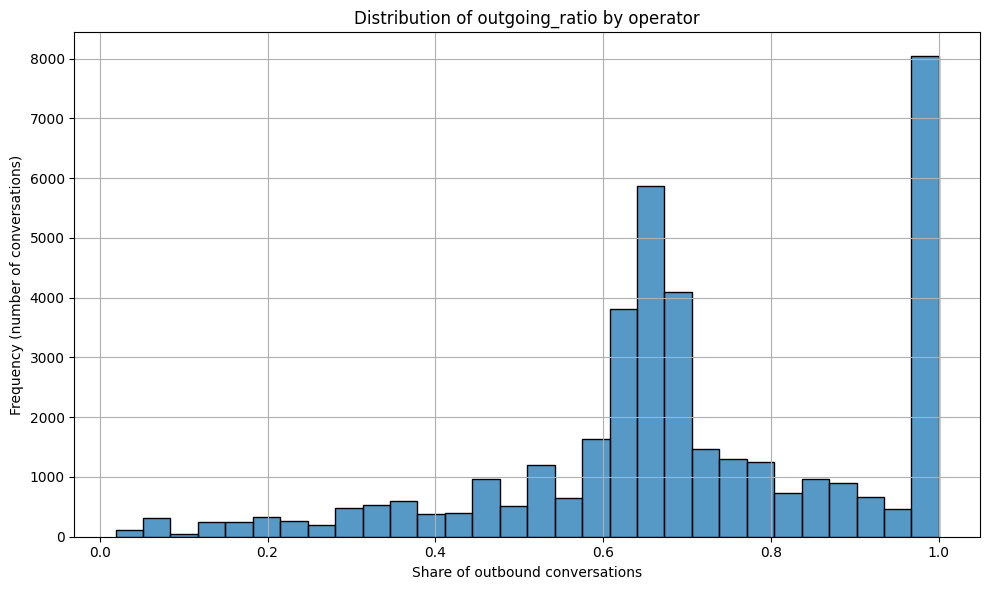

/var/folders/p1/6xjs3nrj1114kr5qgj0jm4cr0000gn/T/ipykernel_54398/3693892730.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  operator_ratio.groupby('range')['operator_id']


,range,n_operators
0,0–10%,10
1,10–40%,101
2,40–70%,249
3,70–90%,125
4,90–100%,348


In [77]:
# Filter: external calls (non-internal) with an assigned operator
external_op_filter = (
    (calls_clean['is_internal'] == False) &
    (calls_clean['operator_id'].notna())
)
external_calls_with_operator = calls_clean[external_op_filter]

# Total conversations per operator (external only)
total_per_operator = external_calls_with_operator.groupby('operator_id').size()

# Outbound conversations per operator (external only)
outbound_per_operator = (
    external_calls_with_operator.query("direction == 'out'")
    .groupby('operator_id')
    .size()
)

# Compute outbound ratio WITHOUT imputing missing values
outgoing_ratio = outbound_per_operator / total_per_operator

# Drop any previous column that starts with 'outgoing_ratio' (safe re-run)
calls_clean.drop(
    columns=[col for col in calls_clean.columns if col.startswith('outgoing_ratio')],
    inplace=True
)

# Merge the metric back into the main DataFrame by operator_id
calls_clean = calls_clean.merge(
    outgoing_ratio.rename('outgoing_ratio'),
    how='left',
    left_on='operator_id',
    right_index=True
)

# Optional: force internal calls to NA (kept commented out intentionally)
# calls_clean.loc[calls_clean['is_internal'] == True, 'outgoing_ratio'] = pd.NA

# Show a few valid examples
display(calls_clean.query("outgoing_ratio.notna()").head())

# Histogram: distribution of outgoing_ratio across operators
plt.figure(figsize=(10, 6))
sns.histplot(calls_clean['outgoing_ratio'].dropna(), bins=30, kde=False)
plt.title('Distribution of outgoing_ratio by operator')
plt.xlabel('Share of outbound conversations')
plt.ylabel('Frequency (number of conversations)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Bin operators into ranges to understand role patterns
operator_ratio = calls_clean[['operator_id', 'outgoing_ratio']].drop_duplicates()
operator_ratio = operator_ratio[operator_ratio['outgoing_ratio'].notna()]

operator_ratio['range'] = pd.cut(
    operator_ratio['outgoing_ratio'],
    bins=[-0.01, 0.1, 0.4, 0.7, 0.9, 1.01],
    labels=["0–10%", "10–40%", "40–70%", "70–90%", "90–100%"]
)

# Count unique operators per range
distribution = (
    operator_ratio.groupby('range')['operator_id']
    .nunique()
    .reset_index(name='n_operators')
)
display(distribution)

In [78]:
# Operator role classification based on outbound activity
# - outbound: 100% of external conversations are outgoing
# - inbound: ≤ 30% outgoing (primarily handles incoming calls)
# - mixed: between 30% and 100% outgoing
# - unknown: insufficient data to determine role
def classify_operator_type(outgoing_ratio):
    if pd.isna(outgoing_ratio):
        return 'unknown'
    elif outgoing_ratio == 1:
        return 'outbound'
    elif outgoing_ratio <= 0.30:
        return 'inbound'
    else:
        return 'mixed'

# Apply classification
calls_clean['op_type'] = calls_clean['outgoing_ratio'].apply(classify_operator_type)

# Inspect sample of classified operators
display(calls_clean[calls_clean['op_type'] != "unknown"].head(3))

# Distribution of operator types
calls_clean['op_type'].value_counts(dropna=False)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,...,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type
1,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5,2019-08-05,...,NaN,False,5,<NA>,False,False,0,False,0.870968,mixed
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,...,NaN,False,1,<NA>,False,False,0,False,0.588235,mixed
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,2019-08-05,...,NaN,True,<NA>,8,False,False,0,False,0.588235,mixed


op_type
mixed       29010
unknown     10336
outbound     7545
inbound      2111
Name: count, dtype: int64

In [79]:
pd.set_option('display.max_columns', None)

# --- Compute missed inbound external conversation ratio per operator ---
# Goal: for each operator, estimate the share of inbound *external* conversations that were missed.

# Filter: inbound + external + assigned operator (the relevant universe for "missed inbound calls")
mask_inbound_external = (
    (calls_clean['is_internal'] == False) &
    (calls_clean['direction'] == "in") &
    (calls_clean['operator_id'].notna())
)

inbound_external = calls_clean[mask_inbound_external]

# Total inbound external conversations per operator
total_inbound = inbound_external.groupby('operator_id').size()

# Missed inbound external conversations per operator
missed_inbound = inbound_external[inbound_external['is_missed_call'] == True].groupby('operator_id').size()

# Missed ratio per operator (NaN for operators with no inbound external conversations)
conv_missed_ratio = missed_inbound / total_inbound

# Remove any previous versions of this metric to avoid duplicates after reruns
cols_to_drop = [c for c in calls_clean.columns if c.startswith('conv_missed_ratio')]
calls_clean.drop(columns=cols_to_drop, inplace=True)

# Merge back to the main table (operator-level metric attached to each conversation row)
calls_clean = calls_clean.merge(
    conv_missed_ratio.rename('conv_missed_ratio'),
    how='left',
    left_on='operator_id',
    right_index=True
)

# Keep this metric only for rows that belong to the inbound-external universe; otherwise set to NA
calls_clean.loc[~mask_inbound_external, 'conv_missed_ratio'] = pd.NA

# Ensure missing values are consistently represented as pd.NA (for cleaner downstream logic)
calls_clean['conv_missed_ratio'] = calls_clean['conv_missed_ratio'].where(
    calls_clean['conv_missed_ratio'].notna(),
    pd.NA
)

display(calls_clean.query('conv_missed_ratio.notna()').head(3))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio
738,166405,2019-08-16 00:00:00+03:00,in,False,882686,False,1,250,287,2019-08-16,False,NaN,True,<NA>,37,False,False,4,True,0.688073,mixed,0.044118
742,166405,2019-08-17 00:00:00+03:00,in,False,882686,False,2,292,314,2019-08-17,False,NaN,True,<NA>,22,False,False,5,True,0.688073,mixed,0.044118
745,166405,2019-08-17 00:00:00+03:00,in,False,882684,False,1,259,270,2019-08-17,False,NaN,True,<NA>,11,False,False,5,True,0.668874,mixed,0.080000


In [80]:
# --- Average inbound external waiting time per operator ---
# Filter: inbound + external + assigned operator (universe used to compute operator-level averages)
mask_inbound_external = (
    (calls_clean['is_internal'] == False) &
    (calls_clean['direction'] == "in") &
    (calls_clean['operator_id'].notna()) &
    (calls_clean['is_outlier_wait'] == False)
)

# Combine both waiting time columns into a single "total waiting time per conversation"
# - waiting_time_valid: answered calls (call_duration > 0)
# - waiting_time_missed: missed calls (call_duration == 0)
calls_clean['waiting_time_ttl'] = (
    calls_clean['waiting_time_valid'].fillna(0) +
    calls_clean['waiting_time_missed'].fillna(0)
)

# Compute mean waiting time per operator (only within inbound external universe)
wait_avg_per_operator = (
    calls_clean[mask_inbound_external]
    .groupby('operator_id')['waiting_time_ttl']
    .mean()
)

# Remove any previous versions of this metric to avoid duplicates after reruns
cols_to_drop = [c for c in calls_clean.columns if c.startswith('wait_avg_op')]
calls_clean.drop(columns=cols_to_drop, inplace=True)

# Merge back to the main table (operator-level metric attached to each conversation row)
calls_clean = calls_clean.merge(
    wait_avg_per_operator.rename('wait_avg_op'),
    how='left',
    left_on='operator_id',
    right_index=True
)

# (Optional) Keep this metric only for inbound-external rows; otherwise set to NA
# If you want that behavior, uncomment the line below:
# calls_clean.loc[~mask_inbound_external, 'wait_avg_op'] = pd.NA

# Quick sanity checks
display(calls_clean[calls_clean['wait_avg_op'].notna()].sample(3))
print(f"Conversations used for the average: {calls_clean[mask_inbound_external].shape[0]}")
print("Conversations with wait_avg_op filled:", calls_clean['wait_avg_op'].notna().sum())
print("Operators with wait_avg_op computed:", calls_clean.query('wait_avg_op.notna()')['operator_id'].nunique())

print(
    "Outliers excluded from wait_avg_op:",
    calls_clean[mask_inbound_external == False]
        .query('is_outlier_wait == True')
        .shape[0]
)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op
25866,167150,2019-09-24 00:00:00+03:00,in,False,905566,False,1,18,32,2019-09-24,False,NaN,True,<NA>,14,False,False,1,True,0.809917,mixed,NaN,14,31.086957
1728,166405,2019-11-27 00:00:00+03:00,out,False,902532,False,19,2432,2711,2019-11-27,False,NaN,True,<NA>,279,False,False,2,False,0.669903,mixed,NaN,279,119.705882
10122,166671,2019-09-23 00:00:00+03:00,in,False,888520,False,1,43,54,2019-09-23,False,NaN,True,<NA>,11,False,False,0,True,NaN,unknown,NaN,11,18.8


Conversations used for the average: 12210
Conversations with wait_avg_op filled: 33820
Operators with wait_avg_op computed: 738
Outliers excluded from wait_avg_op: 3323


In [81]:
# Calls where calls_count > 1
display(calls_clean[calls_clean['calls_count'] > 1].sample(5))

# Compare with unique row counts per user_id + date (to understand row granularity)
print(calls_clean.groupby(['user_id', 'date_no_tz']).size().value_counts().head())

# Number of unique client accounts
calls_clean['user_id'].nunique()

# Check whether there are multiple rows per operator and date
print(calls_clean.groupby(['operator_id', 'date_no_tz']).size().value_counts().head())

# Validate whether total rows match the total number of calls reported in calls_count
total_records = calls_clean.shape[0]
total_calls_reported = calls_clean['calls_count'].sum()

print(f"Total records (rows): {total_records}")
print(f"Total calls reported (sum of calls_count): {total_calls_reported}\n")

# --- calls_count investigation ---

# Group by user_id, operator_id, and date to detect repeated conversations per day
combinations = (
    calls_clean
    .groupby(['user_id', 'operator_id', 'date_no_tz'])
    .size()
    .reset_index(name='n_conversations')
)

# Examples where the same user_id + operator_id has more than one conversation in the same day
duplicates = combinations[combinations['n_conversations'] > 1]

display(duplicates.head())
print("Combinations with more than 1 conversation on the same day:", duplicates.shape[0])

# Inspect specific cases (same client + operator across multiple days)
display(calls_clean[
    (calls_clean['user_id'] == 166377) &
    (calls_clean['operator_id'] == "880020") &
    (calls_clean['date_no_tz'] == "2019-08-05")
])

display(calls_clean[
    (calls_clean['user_id'] == 166377) &
    (calls_clean['operator_id'] == "880020") &
    (calls_clean['date_no_tz'] == "2019-08-06")
])

display(calls_clean[
    (calls_clean['user_id'] == 166377) &
    (calls_clean['operator_id'] == "880020") &
    (calls_clean['date_no_tz'] == "2019-09-02")
])

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op
20133,166997,2019-10-08 00:00:00+03:00,out,False,903318,True,2,0,8,2019-10-08,False,NaN,False,8,<NA>,False,False,1,False,0.660714,mixed,NaN,8,45.140351
21278,167031,2019-09-26 00:00:00+03:00,out,False,910520,False,2,31,44,2019-09-26,False,NaN,True,<NA>,13,False,False,3,False,1.000000,outbound,NaN,13,<NA>
51272,168271,2019-11-25 00:00:00+03:00,out,False,954650,False,20,815,1126,2019-11-25,False,NaN,True,<NA>,311,False,False,0,False,0.637931,mixed,NaN,311,229.0
53834,168601,2019-11-12 00:00:00+03:00,out,False,952914,False,27,1682,2011,2019-11-12,False,NaN,True,<NA>,329,False,False,1,False,0.687500,mixed,NaN,329,38.866667
26324,167150,2019-10-23 00:00:00+03:00,out,False,905538,False,16,916,1138,2019-10-23,False,NaN,True,<NA>,222,False,False,2,False,0.678571,mixed,NaN,222,79.518519


1    3242
2    1664
3    1331
4    1202
5     579
Name: count, dtype: int64
1    6636
2    6269
3    5069
4    1239
5     399
Name: count, dtype: int64
Total records (rows): 49002
Total calls reported (sum of calls_count): 806709



,user_id,operator_id,date_no_tz,n_conversations
0,166377,880020,2019-08-05,4
1,166377,880020,2019-08-06,2
4,166377,880020,2019-09-02,2
11,166377,880020,2019-09-30,2
14,166377,880022,2019-08-05,2


Combinations with more than 1 conversation on the same day: 13011


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1,2019-08-05,True,NaN,False,1,<NA>,False,False,0,False,0.588235,mixed,NaN,1,7.714286
3,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18,2019-08-05,True,NaN,True,<NA>,8,False,False,0,False,0.588235,mixed,NaN,8,7.714286
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29,2019-08-05,False,NaN,True,<NA>,26,False,False,0,False,0.588235,mixed,NaN,26,7.714286
6,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50,2019-08-05,False,NaN,False,50,<NA>,False,False,0,False,0.588235,mixed,NaN,50,7.714286


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op
11,166377,2019-08-06 00:00:00+03:00,out,False,880020,True,5,0,70,2019-08-06,False,NaN,False,70,<NA>,False,False,1,False,0.588235,mixed,NaN,70,7.714286
13,166377,2019-08-06 00:00:00+03:00,out,False,880020,False,5,800,819,2019-08-06,False,NaN,True,<NA>,19,False,False,1,False,0.588235,mixed,NaN,19,7.714286


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op
124,166377,2019-09-02 00:00:00+03:00,out,True,880020,True,2,0,0,2019-09-02,True,NaN,False,0,<NA>,False,False,0,False,0.588235,mixed,NaN,0,7.714286
125,166377,2019-09-02 00:00:00+03:00,out,False,880020,True,2,0,3,2019-09-02,False,NaN,False,3,<NA>,False,False,0,False,0.588235,mixed,NaN,3,7.714286


In [82]:
# --- Internal call ratio per operator ---
# This metric captures how much of an operator's activity is internal
# (i.e., calls between operators within the same organization)

# Count internal conversations per operator
internal_calls = (
    calls_clean[calls_clean['is_internal'] == True]
    .groupby('operator_id')
    .size()
)

# Count total conversations per operator (all directions, all types)
total_calls = (
    calls_clean[calls_clean['operator_id'].notna()]
    .groupby('operator_id')
    .size()
)

# Compute internal call ratio
# = internal conversations / total conversations per operator
internal_call_ratio = (internal_calls / total_calls).fillna(0)

# Remove any previous versions of this metric to avoid duplication
cols_to_drop = [col for col in calls_clean.columns if col.startswith('internal_call_ratio')]
calls_clean.drop(columns=cols_to_drop, inplace=True)

# Merge operator-level metric back into the main conversation-level table
calls_clean = calls_clean.merge(
    internal_call_ratio.rename('internal_call_ratio'),
    how='left',
    left_on='operator_id',
    right_index=True
)

# (Optional) Set NA for rows without operator_id
# calls_clean.loc[calls_clean['operator_id'].isna(), 'internal_call_ratio'] = pd.NA

# Sanity checks
display(calls_clean[['operator_id', 'is_internal', 'internal_call_ratio']].sample(5))
print("Operators with internal_call_ratio computed:", internal_call_ratio.shape[0])

display(calls_clean.sample(2))

,operator_id,is_internal,internal_call_ratio
51598,948756,False,0.250000
41891,930020,False,0.060606
4247,NaN,False,NaN
24348,907178,True,0.468750
4771,891414,False,0.208835


Operators with internal_call_ratio computed: 1092


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op,internal_call_ratio
17785,166955,2019-09-04 00:00:00+03:00,in,False,898558,False,3,32,117,2019-09-04,False,NaN,True,<NA>,85,False,False,2,True,NaN,unknown,NaN,85,51.833333,0.000000
1162,166405,2019-10-10 00:00:00+03:00,out,False,902510,True,31,0,389,2019-10-10,False,NaN,False,389,<NA>,False,False,3,False,0.783333,mixed,NaN,389,157.961538,0.008264


In [83]:
# --- Missed inbound internal conversation ratio per operator ---
# Focus: internal + inbound conversations that were assigned to an operator.
# This metric helps evaluate missed internal coordination/transfer calls.

# Filter: inbound internal conversations with an assigned operator
mask_internal_inbound = (
    (calls_clean['is_internal'] == True) &
    (calls_clean['direction'] == "in") &
    (calls_clean['operator_id'].notna())
)

internal_inbound_calls = calls_clean[mask_internal_inbound]

# Total inbound internal conversations per operator
total_internal_inbound = internal_inbound_calls.groupby('operator_id').size()

# Missed inbound internal conversations per operator
missed_internal_inbound = (
    internal_inbound_calls[internal_inbound_calls['is_missed_call'] == True]
    .groupby('operator_id')
    .size()
)

# Ratio = missed / total (operator-level)
conv_missed_ratio_internal = missed_internal_inbound / total_internal_inbound

# Remove any previous version to avoid duplicates after reruns
calls_clean = calls_clean.drop(columns=['conv_missed_ratio_internas'], errors='ignore')

# Merge operator-level metric back into the main conversation-level table
calls_clean = calls_clean.merge(
    conv_missed_ratio_internal.rename('conv_missed_ratio_internas'),
    how='left',
    left_on='operator_id',
    right_index=True
)

# (Optional) Keep this metric only for rows in the internal-inbound universe; otherwise set to NA
# calls_clean.loc[~mask_internal_inbound, 'conv_missed_ratio_internas'] = pd.NA

# Quick checks
display(calls_clean.query('conv_missed_ratio_internas > 0').sample(2))
calls_clean.info()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op,internal_call_ratio,conv_missed_ratio_internas
2398,166407,2019-10-09 00:00:00+03:00,out,True,888534,True,1,0,16,2019-10-09,True,NaN,False,16,<NA>,False,False,2,False,0.609756,mixed,NaN,16,52.25,0.388060,0.25
44375,168041,2019-11-13 00:00:00+03:00,in,False,934534,False,2,144,188,2019-11-13,False,NaN,True,<NA>,44,False,False,2,True,NaN,unknown,NaN,44,64.694444,0.052632,1.00


<class 'pandas.core.frame.DataFrame'>
Index: 49002 entries, 0 to 53901
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype                    
---  ------                      --------------  -----                    
 0   user_id                     49002 non-null  int64                    
 1   date                        49002 non-null  datetime64[ns, UTC+03:00]
 2   direction                   49002 non-null  object                   
 3   internal                    48892 non-null  object                   
 4   operator_id                 41546 non-null  object                   
 5   is_missed_call              49002 non-null  bool                     
 6   calls_count                 49002 non-null  int64                    
 7   call_duration               49002 non-null  int64                    
 8   total_call_duration         49002 non-null  int64                    
 9   date_no_tz                  49002 non-null  datetime64[ns]        

In [84]:
# --- Average inbound internal waiting time per operator (excluding outliers) ---

# Filter: inbound + internal + assigned operator + no extreme waiting outliers
mask_internal_inbound_valid = (
    (calls_clean['is_internal'] == True) &
    (calls_clean['direction'] == "in") &
    (calls_clean['operator_id'].notna()) &
    (~calls_clean['is_outlier_wait'])
)

# Compute average total waiting time per operator (internal inbound conversations)
wait_avg_internal = (
    calls_clean[mask_internal_inbound_valid]
    .groupby('operator_id')['waiting_time_ttl']
    .mean()
)

# Remove any previous version to avoid duplication on reruns
calls_clean.drop(
    columns=[col for col in calls_clean.columns if col.startswith('wait_avg_internal')],
    inplace=True
)

# Merge operator-level metric back to conversation-level table
calls_clean = calls_clean.merge(
    wait_avg_internal.rename('wait_avg_internal'),
    how='left',
    left_on='operator_id',
    right_index=True
)

# (Optional) Keep this metric only for internal inbound rows
# calls_clean.loc[~mask_internal_inbound_valid, 'wait_avg_internal'] = pd.NA

# Quick sanity check
display(calls_clean.query('wait_avg_internal.notna()').sample(2))
print("Operators with internal waiting time calculated:",
      calls_clean.query('wait_avg_internal.notna()')['operator_id'].nunique())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op,internal_call_ratio,conv_missed_ratio_internas,wait_avg_internal
12821,166782,2019-09-18 00:00:00+03:00,out,False,893804,True,18,0,280,2019-09-18,False,NaN,False,280,<NA>,False,False,2,False,0.609195,mixed,NaN,280,121.833333,0.096886,NaN,6.2
4237,166503,2019-10-31 00:00:00+03:00,in,False,884412,False,1,94,127,2019-10-31,False,NaN,True,<NA>,33,False,False,3,True,0.865385,mixed,NaN,33,50.071429,0.079646,NaN,24.5


Operators with internal waiting time calculated: 149


In [85]:
# --- Total outbound external conversations per operator (excluding extreme outliers) ---
mask_outbound_external = (
    (calls_clean['direction'] == 'out') &
    (calls_clean['is_internal'] == False) &
    (calls_clean['operator_id'].notna()) &
    (~calls_clean['is_outlier_wait']) &
    (~calls_clean['is_outlier_duration'])
)

# Count outbound external conversations per operator
conv_out_total = (
    calls_clean[mask_outbound_external]
    .groupby('operator_id')
    .size()
)

# Remove any previous versions to avoid duplicates after reruns
calls_clean.drop(
    columns=[c for c in calls_clean.columns if c.startswith('conv_out_total')],
    inplace=True
)

# Merge operator-level metric back to the conversation-level table
calls_clean = calls_clean.merge(
    conv_out_total.rename('conv_out_total'),
    how='left',
    left_on='operator_id',
    right_index=True
)

# Quick sanity check
display(calls_clean.query('conv_out_total.notna()').sample(2))
print("Operators with outbound external conversations:",
      (calls_clean.groupby('operator_id')['conv_out_total'].max() > 0).sum())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op,internal_call_ratio,conv_missed_ratio_internas,wait_avg_internal,conv_out_total
39528,167747,2019-10-30 00:00:00+03:00,out,False,922428,True,2,0,55,2019-10-30,False,NaN,False,55,<NA>,False,False,2,False,0.709091,mixed,NaN,55,14.25,0.191176,NaN,<NA>,39.0
44907,168062,2019-11-13 00:00:00+03:00,out,False,947612,True,1,0,0,2019-11-13,False,NaN,False,0,<NA>,False,False,2,False,0.968750,mixed,NaN,0,18.0,0.135135,NaN,<NA>,31.0


Operators with outbound external conversations: 831


In [86]:
# Calculate the ratio between effective call duration and total waiting time
# This metric captures how much actual conversation occurred relative to the time a user waited.
# Higher values indicate more efficient interactions (less waiting per unit of talk time).
# If waiting_time_ttl is zero or missing, the ratio is set to NA to avoid invalid divisions.
calls_clean['call_to_wait_ratio'] = np.where(
    calls_clean['waiting_time_ttl'] > 0,
    calls_clean['call_duration'] / calls_clean['waiting_time_ttl'],
    pd.NA
)

display(calls_clean.sample(2))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op,internal_call_ratio,conv_missed_ratio_internas,wait_avg_internal,conv_out_total,call_to_wait_ratio
28896,167188,2019-11-22 00:00:00+03:00,in,False,962168,False,1,153,173,2019-11-22,False,NaN,True,<NA>,20,False,False,4,True,NaN,unknown,NaN,20,19.0,0.25,NaN,12.0,NaN,7.65
12129,166717,2019-10-15 00:00:00+03:00,in,False,891988,False,1,20,26,2019-10-15,False,NaN,True,<NA>,6,False,False,1,True,0.625,mixed,NaN,6,61.349206,0.00,NaN,<NA>,105.0,3.333333


### Conclusion of the Data Enrichment Stage

Before starting the exploratory analysis, a dedicated data enrichment stage was carried out to better understand the structure of the dataset and to construct the key metrics required to evaluate operator performance.

A critical finding at this stage is that each row in the dataset represents a **conversation**, not an individual call. This distinction is fundamental and directly informs the design and interpretation of all subsequent metrics.

Using the event-level data, multiple operator-level indicators were derived by aggregating information at the `operator_id` level. The main enriched metrics include:

- **`wait_avg_op`**: Average waiting time for inbound external conversations, calculated excluding extreme outliers.
- **`wait_avg_internal`**: Average waiting time for inbound internal conversations.
- **`conv_missed_ratio`**: Proportion of missed inbound external conversations per operator.
- **`conv_missed_ratio_internas`**: Proportion of missed inbound internal conversations.
- **`conv_out_total`**: Total number of outbound external conversations initiated by the operator.
- **`internal_call_ratio`**: Share of internal conversations relative to the operator’s total activity.
- **`call_to_wait_ratio`**: Ratio between effective call duration and total waiting time, explored as an experimental efficiency indicator.

Together, these features consolidate a primary analytical dataset at the **operator level**, which serves as the foundation for all subsequent exploratory analysis and performance evaluation.

Additionally, a behavioral classification logic was implemented to segment operators by activity profile. An **`outgoing_ratio`** was computed to represent the proportion of outbound conversations initiated by each operator. Based on this ratio, operators were classified into the following categories:

- **`outbound`**: Operators exclusively performing outbound conversations.
- **`inbound`**: Operators primarily handling inbound conversations.
- **`mixed`**: Operators combining inbound and outbound activity.
- **`unknown`**: Operators without sufficient information to be reliably classified.

This enrichment stage results in a structured and behaviorally meaningful dataset, enabling a clear transition into the exploratory analysis and the identification of potentially inefficient operators.

# Exploratory Data Analysis (EDA)

In this stage, we analyze the overall behavior of the dataset to identify **patterns of operational inefficiency**.  
The primary objective is to detect underperforming operators using behavior-driven metrics, while also understanding the broader context of call center activity.

> **Important:** each row represents a **conversation** (not an individual call). Several variables reflect conversation-level behavior, while others are aggregated at the operator level.

---

## Basic Distributions

We begin by visualizing the distributions of key variables to understand their general behavior and to detect extreme values or anomalies.  
The selected variables are directly related to operational performance and operator efficiency.

| Variable                       | Visualization              | Purpose |
|--------------------------------|----------------------------|---------|
| `call_duration`               | Truncated histogram        | Evaluates the duration of answered conversations and highlights abnormal sessions. |
| `waiting_time_ttl`            | Truncated histogram        | Captures total waiting time per conversation, including answered and missed cases. |
| `call_to_wait_ratio`          | Truncated histogram        | Exploratory metric to assess how waiting time translates into actual conversation time. |
| `wait_avg_op`                | Histogram                  | Compares average inbound external waiting time across operators (outliers excluded). |
| `wait_avg_internal`           | Histogram                  | Measures internal communication responsiveness. |
| `conv_missed_ratio`           | Histogram                  | Share of missed inbound external conversations per operator. |
| `conv_missed_ratio_internas`  | Histogram                  | Share of missed inbound internal conversations. |
| `weekday`                    | Count plot                 | Shows conversation volume by day of the week. |
| `op_type`                    | Count plot                 | Distribution of operators by activity profile (inbound, outbound, mixed). |

<br>
> *Note:* `call_to_wait_ratio` is explored at this stage to understand behavioral patterns but is not used as a decisive metric in later classification or statistical validation steps.

---

## Focused EDA: Identifying Inefficient Operators

Once the global distributions are understood, the analysis shifts toward identifying **potentially inefficient operators**.  
This step relies on logical rules derived from statistical thresholds and from the expected behavior associated with each operator type.

### Key operator-level metrics

The following metrics are computed at the operator level and serve as signals of operational inefficiency:

| Metric                      | Description                                                                  | Inefficiency signal |
|-----------------------------|------------------------------------------------------------------------------|---------------------|
| `wait_avg_op`               | Average waiting time for inbound external conversations (outliers excluded) | High                |
| `wait_avg_internal`         | Average waiting time for inbound internal conversations                       | High                |
| `conv_missed_ratio`         | Proportion of missed inbound external conversations                           | High                |
| `conv_missed_ratio_internas`| Proportion of missed inbound internal conversations                           | High                |
| `conv_out_total`            | Total number of outbound external conversations                               | Low (for outbound operators) |
| `outbound_calls_avg`        | Average number of outbound conversations per day                              | Low (for outbound operators) |

---

### Analytical approach

Using aggregations by `operator_id`, we construct operator-level summaries to:

- Evaluate whether **outbound operators** meet the expectations implied by their `op_type`
- Identify operators showing inefficiency signals even if only one metric deviates significantly

Automatic classification rules are then defined using **distribution percentiles** for each metric, segmented by operator type when appropriate.  
This percentile-based approach allows for an objective prioritization of operators with the highest risk of operational inefficiency, while preserving contextual fairness across different operator roles.

### 📌 Outliers in Number of Calls per Conversation (`calls_count`)

Although each row in the dataset represents a **conversation**, some conversations aggregate an unusually high number of calls.  
These extreme cases may correspond to technical retries, routing loops, or prolonged interaction chains, and can distort distribution-based analyses.

To identify these cases, the **Interquartile Range (IQR)** method was applied to the `calls_count` variable.

- Conversations above `Q3 + 1.5 × IQR` were flagged as outliers.
- These cases represent a **small proportion of the dataset**, but can heavily influence averages and histograms.

Importantly:

- **Outliers were not removed globally from the dataset.**
- Instead, a filtered version (`calls_filtered`) was created and used **selectively** in exploratory visualizations where distribution shape matters.
- All operator-level metrics and classification rules continue to rely on the full, logically validated dataset.

This approach preserves data integrity while ensuring robust exploratory insights.

In [87]:
# --- Detect outliers in number of calls per conversation (calls_count) using IQR ---
# Although each row represents a conversation, some conversations aggregate
# an unusually high number of calls, which may distort averages and distributions.

# Step 1: Compute Q1, Q3 and the Interquartile Range (IQR)
Q1 = calls_clean['calls_count'].quantile(0.25)
Q3 = calls_clean['calls_count'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define the upper bound for outliers
upper_bound = Q3 + 1.5 * IQR

# Step 3: Flag conversations with unusually high call counts
calls_clean['is_outlier_calls_count'] = calls_clean['calls_count'] > upper_bound

# Step 4: Compute proportion of conversations flagged as outliers
outlier_ratio = calls_clean['is_outlier_calls_count'].mean() * 100

# Display results
print(f'Proportion of outliers by calls_count: {outlier_ratio:.2f}%')
print(f'IQR upper bound for calls_count: {upper_bound}')

# Create a filtered version excluding extreme call aggregation cases
# (used selectively in exploratory analysis)
calls_filtered = calls_clean[~calls_clean['is_outlier_calls_count']].copy()

Proportion of outliers by calls_count: 12.34%
IQR upper bound for calls_count: 28.5


### 📊 Distribution Analysis of Key Operational Metrics

The following visualizations explore the distribution of key efficiency metrics using
a filtered version of the dataset (`calls_filtered`), where extreme cases of call aggregation
have been excluded for clarity.

Although each row represents a **conversation**, several metrics shown below
(e.g., `wait_avg_op`, `conv_missed_ratio`) are **operator-level aggregates**
replicated across conversations. This allows us to inspect their empirical distribution
while preserving the conversational structure of the data.

These distributions help:
- Identify skewness and long tails
- Detect natural thresholds for inefficiency
- Inform percentile-based rules used later in operator classification

The metric `call_to_wait_ratio` is included only for exploratory purposes and is
not used in the final inefficiency classification.

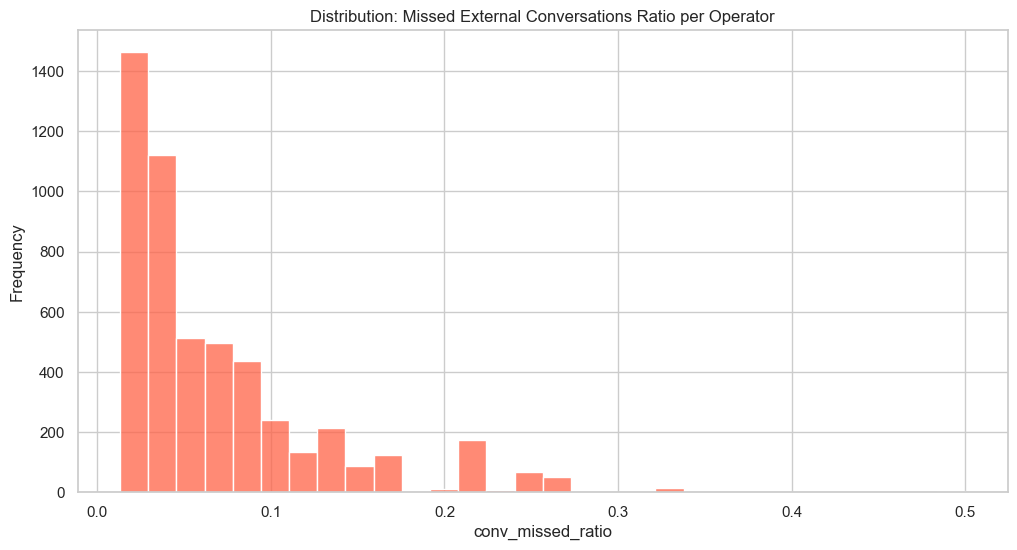

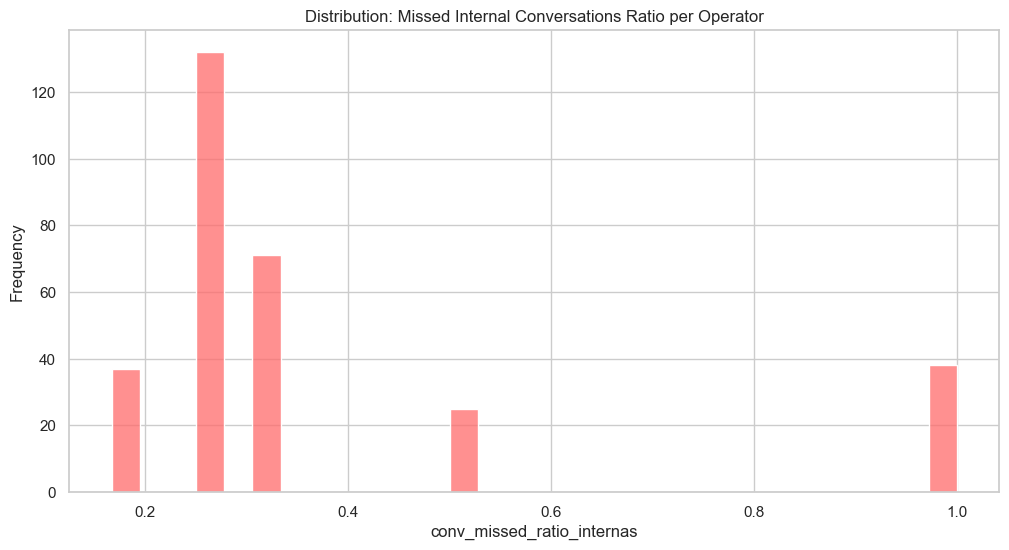

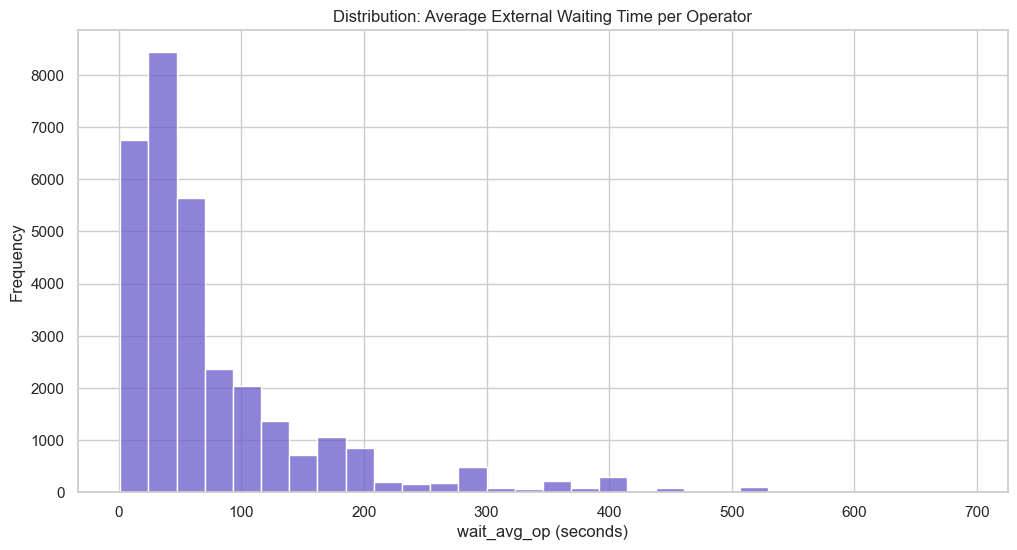

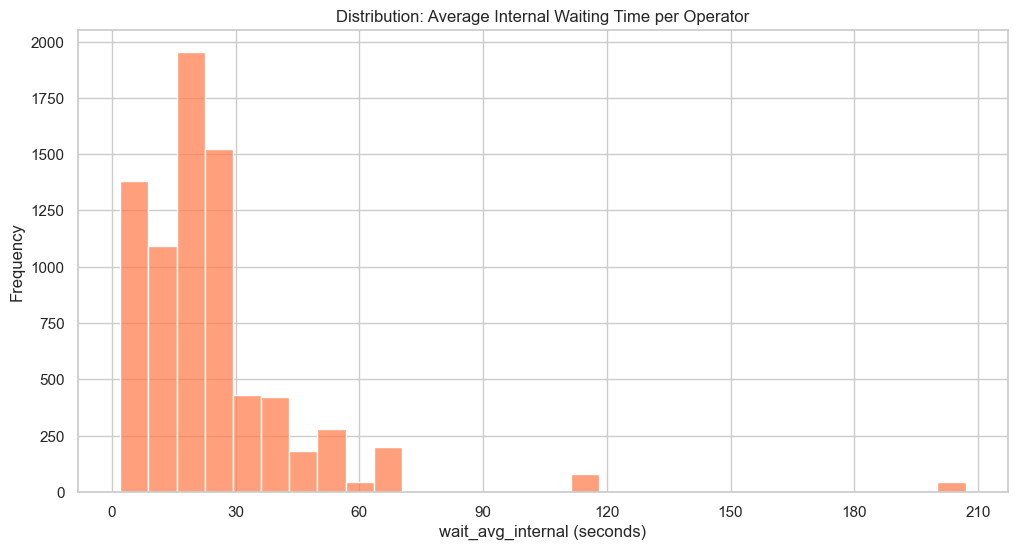

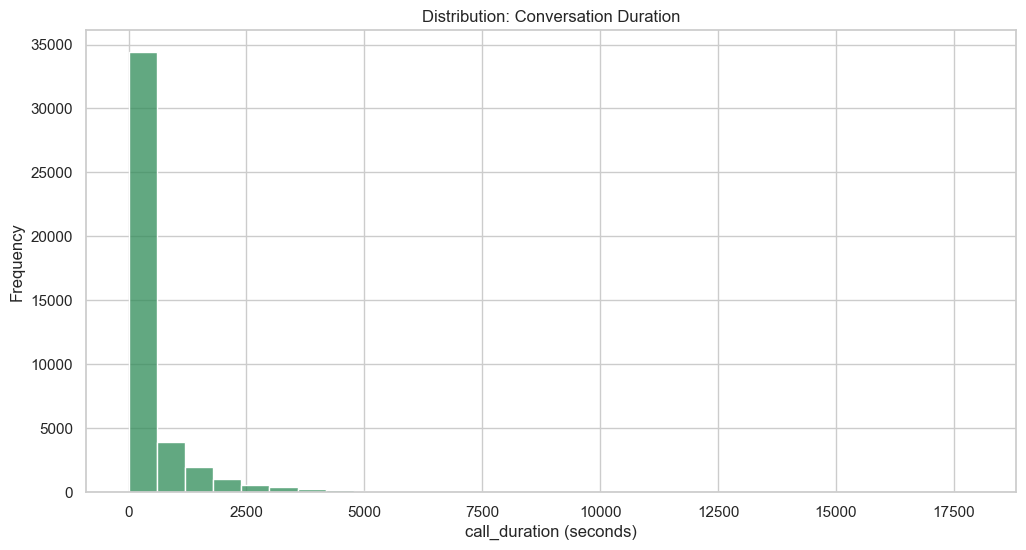

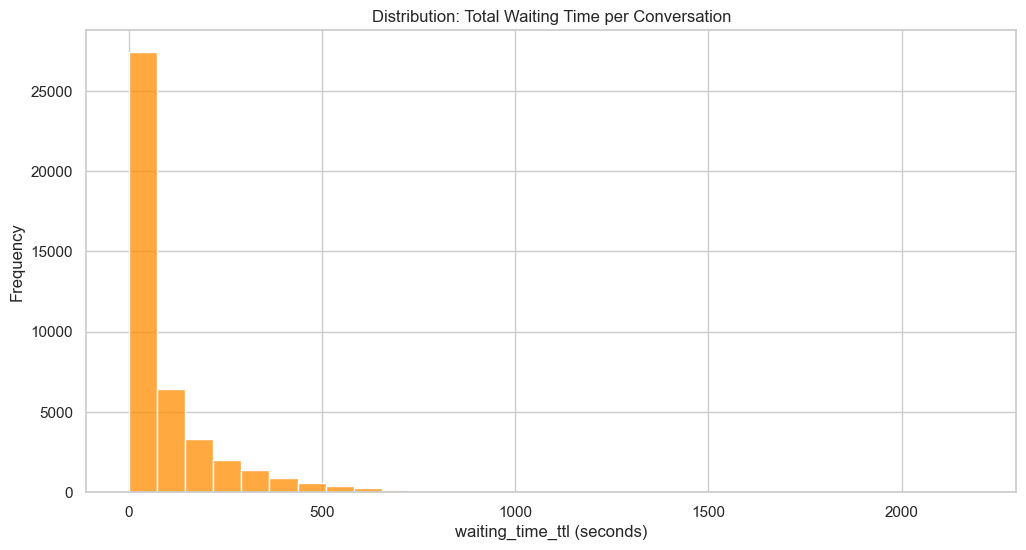

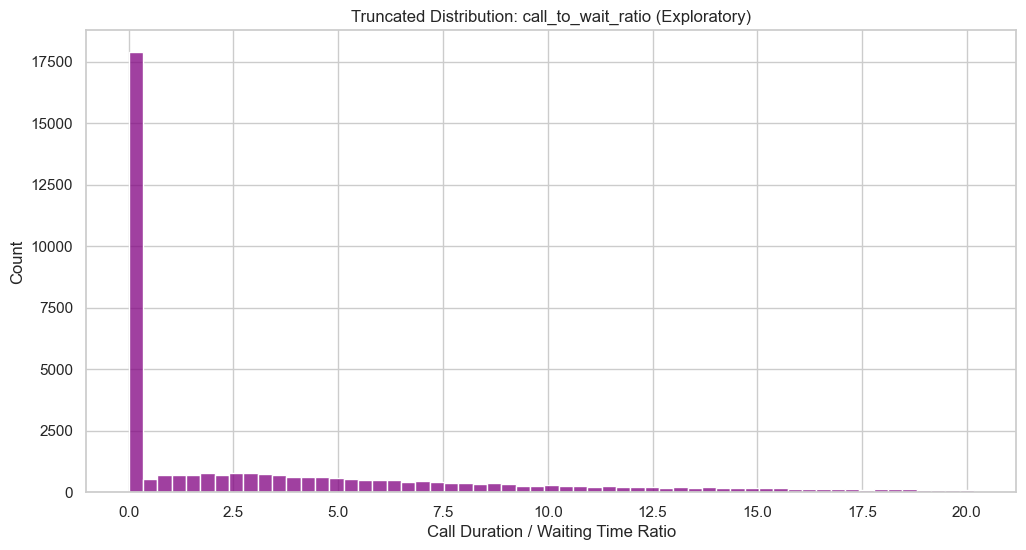

In [88]:
# Ensure relevant metrics are numeric for visualization
cols_to_float = [
    'conv_missed_ratio',
    'conv_missed_ratio_internas', 
    'wait_avg_op',
    'call_duration',
    'waiting_time_ttl',
    'call_to_wait_ratio'
]

for col in cols_to_float:
    calls_filtered[col] = pd.to_numeric(calls_filtered[col], errors='coerce')

# Global plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Distribution: missed inbound external conversations ratio
sns.histplot(data=calls_filtered, x='conv_missed_ratio', bins=30, color='tomato')
plt.title('Distribution: Missed External Conversations Ratio per Operator')
plt.xlabel('conv_missed_ratio')
plt.ylabel('Frequency')
plt.show()

# Distribution: missed internal conversations ratio
sns.histplot(data=calls_filtered, x='conv_missed_ratio_internas', bins=30, color='#FF6B6B')
plt.title('Distribution: Missed Internal Conversations Ratio per Operator')
plt.xlabel('conv_missed_ratio_internas')
plt.ylabel('Frequency')
plt.show()

# Distribution: average waiting time (external conversations)
sns.histplot(data=calls_filtered, x='wait_avg_op', bins=30, color='slateblue')
plt.title('Distribution: Average External Waiting Time per Operator')
plt.xlabel('wait_avg_op (seconds)')
plt.ylabel('Frequency')
plt.show()

# Distribution: average waiting time (internal conversations)
sns.histplot(data=calls_filtered, x='wait_avg_internal', bins=30, color='coral')
plt.title('Distribution: Average Internal Waiting Time per Operator')
plt.xlabel('wait_avg_internal (seconds)')
plt.ylabel('Frequency')
plt.xticks(range(0, 220, 30))
plt.show()

# Distribution: conversation duration
sns.histplot(data=calls_filtered, x='call_duration', bins=30, color='seagreen')
plt.title('Distribution: Conversation Duration')
plt.xlabel('call_duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Distribution: total waiting time per conversation
sns.histplot(data=calls_filtered, x='waiting_time_ttl', bins=30, color='darkorange')
plt.title('Distribution: Total Waiting Time per Conversation')
plt.xlabel('waiting_time_ttl (seconds)')
plt.ylabel('Frequency')
plt.show()

# Distribution: call_to_wait_ratio (exploratory metric, truncated)
Q1 = calls_filtered['call_to_wait_ratio'].quantile(0.25)
Q3 = calls_filtered['call_to_wait_ratio'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

calls_filtered_trunc = calls_filtered[
    calls_filtered['call_to_wait_ratio'] <= upper_bound
]

sns.histplot(x=calls_filtered_trunc['call_to_wait_ratio'], color='purple')
plt.title('Truncated Distribution: call_to_wait_ratio (Exploratory)')
plt.xlabel('Call Duration / Waiting Time Ratio')
plt.show()

/var/folders/p1/6xjs3nrj1114kr5qgj0jm4cr0000gn/T/ipykernel_54398/447539209.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weekday', data=calls_filtered, palette='muted')


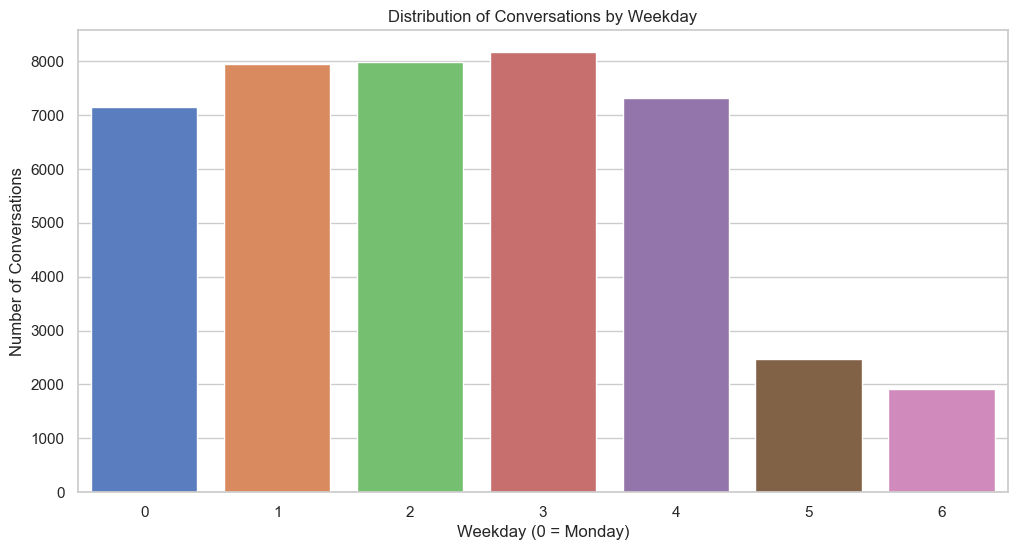

/var/folders/p1/6xjs3nrj1114kr5qgj0jm4cr0000gn/T/ipykernel_54398/447539209.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='op_type', data=calls_filtered, palette='muted')


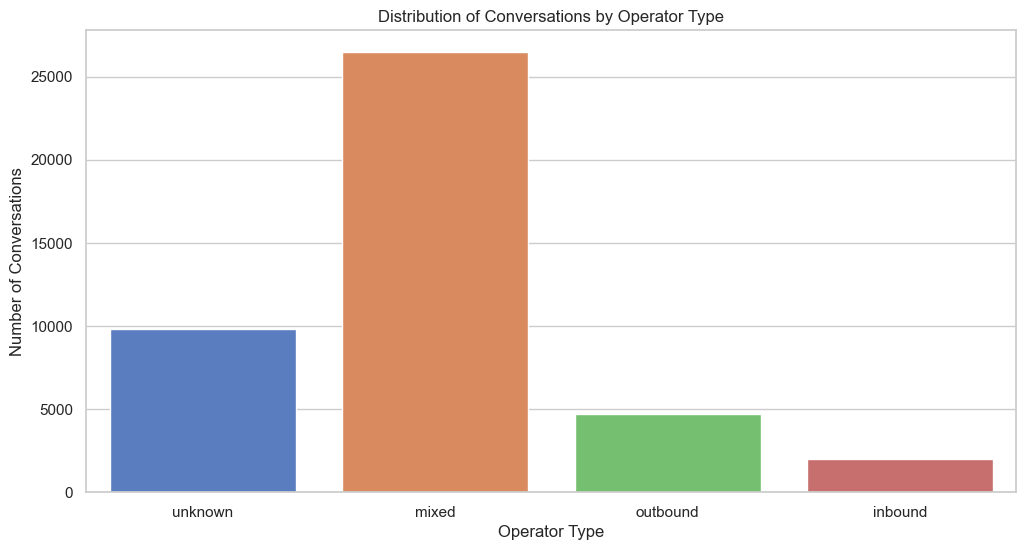

In [89]:
# Distribution of conversations by weekday
sns.countplot(x='weekday', data=calls_filtered, palette='muted')
plt.title('Distribution of Conversations by Weekday')
plt.xlabel('Weekday (0 = Monday)')
plt.ylabel('Number of Conversations')
plt.show()

# Distribution of conversations by operator type
# Note: this shows conversations associated with each operator profile,
# not the number of unique operators
sns.countplot(x='op_type', data=calls_filtered, palette='muted')
plt.title('Distribution of Conversations by Operator Type')
plt.xlabel('Operator Type')
plt.ylabel('Number of Conversations')
plt.show()

In [90]:
# Keep only conversations that are NOT flagged as outliers by call volume (calls_count)
# Note: this filter is redundant if df_valid is already built from calls_filtered,
# but it keeps the step explicit and prevents issues if the notebook is re-run out of order.
df_valid = calls_filtered[calls_filtered['is_outlier_calls_count'] == False].copy()

# Ensure key metrics are numeric (coerce unexpected values to NaN)
cols_to_convert = [
    'wait_avg_op',
    'wait_avg_internal',
    'conv_missed_ratio',
    'conv_missed_ratio_internas',
    'conv_out_total'
]

for col in cols_to_convert:
    df_valid[col] = pd.to_numeric(df_valid[col], errors='coerce')

# Aggregate to operator-level metrics
# - 'mean' is used for ratios/averages that are computed per operator and attached to each row
# - 'conv_out_total' is operator-level already, so we use 'max' (equivalent to 'first' here, but clearer)
# - 'op_type' should be constant per operator, so 'first' is safe
operator_metrics = df_valid.groupby('operator_id').agg({
    'wait_avg_op': 'mean',
    'wait_avg_internal': 'mean',
    'conv_missed_ratio': 'mean',
    'conv_missed_ratio_internas': 'mean',
    'conv_out_total': 'max',
    'op_type': 'first'
}).reset_index()

display(operator_metrics.head())
display(operator_metrics.query('conv_missed_ratio_internas.notna()'))
operator_metrics.info()

,operator_id,wait_avg_op,wait_avg_internal,conv_missed_ratio,conv_missed_ratio_internas,conv_out_total,op_type
0,879896,27.333333,<NA>,NaN,NaN,80.0,mixed
1,879898,29.473684,<NA>,NaN,NaN,115.0,mixed
2,880020,7.714286,<NA>,NaN,NaN,10.0,mixed
3,880022,14.0,<NA>,NaN,NaN,54.0,mixed
4,880026,7.944444,<NA>,NaN,NaN,151.0,mixed


,operator_id,wait_avg_op,wait_avg_internal,conv_missed_ratio,conv_missed_ratio_internas,conv_out_total,op_type
43,888534,52.25,21.0,NaN,0.250000,49.0,mixed
384,914440,31.352941,20.0,NaN,0.500000,NaN,unknown
551,926490,25.166667,31.666667,NaN,0.333333,37.0,mixed
638,934098,35.666667,26.0,0.333333,0.500000,NaN,unknown
647,934534,64.694444,10.5,NaN,1.000000,NaN,unknown
659,935958,40.941176,27.666667,NaN,0.333333,NaN,unknown
720,937962,56.290323,14.5,0.064516,0.166667,NaN,unknown


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operator_id                 1084 non-null   object 
 1   wait_avg_op                 738 non-null    Float64
 2   wait_avg_internal           149 non-null    Float64
 3   conv_missed_ratio           164 non-null    float64
 4   conv_missed_ratio_internas  7 non-null      float64
 5   conv_out_total              825 non-null    float64
 6   op_type                     1084 non-null   object 
dtypes: Float64(2), float64(3), object(2)
memory usage: 61.5+ KB


In [91]:
# ============================================================
# Sanity checks — coverage & applicability of operator metrics
# ------------------------------------------------------------
# Goal:
# Many operator-level metrics are only defined for a specific "universe" of calls.
# For example:
# - conv_missed_ratio only applies to inbound EXTERNAL calls with an assigned operator
# - wait_avg_internal only applies to inbound INTERNAL calls with an assigned operator
#
# Therefore, NaNs in operator_metrics usually mean "not applicable", not missing data.
# These checks quantify how many operators are covered by each metric and confirm
# that the logic is consistent with the operator type (op_type).
# ============================================================

# 1) Coverage of conv_missed_ratio (inbound external missed ratio) after excluding outliers by calls_count
ops_with_conv_missed_ratio = (
    calls_clean
    .query("conv_missed_ratio.notna() and is_outlier_calls_count == False")['operator_id']
    .nunique()
)
print("✅ Operators with conv_missed_ratio available (no calls_count outliers):", ops_with_conv_missed_ratio)

# 2) Inspect outbound operators with missed outbound calls
# Note:
# A "missed" outbound call usually reflects the recipient not answering, and it is not
# the same operational issue as missed INBOUND calls (which imply poor responsiveness).
outbound_missed_out = calls_filtered.query(
    "op_type == 'outbound' and is_missed_call == True and direction == 'out'"
)
print("\n✅ Outbound conversations marked as missed (direction='out'):")
print("   Rows:", outbound_missed_out.shape[0])
print("   Unique operators:", outbound_missed_out['operator_id'].nunique())
display(outbound_missed_out.head(5))

# 3) Validate that conv_missed_ratio is only present for inbound/mixed operators
# If outbound operators had conv_missed_ratio, that would be a logic bug (wrong universe).
conv_missed_inbound_mixed = calls_filtered.query(
    "conv_missed_ratio.notna() and (op_type == 'inbound' or op_type == 'mixed')"
)
conv_missed_outbound = calls_filtered.query(
    "conv_missed_ratio.notna() and op_type == 'outbound'"
)

print("\n✅ conv_missed_ratio rows for inbound/mixed operators:", conv_missed_inbound_mixed.shape[0])
print("⚠️ conv_missed_ratio rows for outbound operators (should be ~0):", conv_missed_outbound.shape[0])

# 4) Coverage of wait_avg_internal (avg waiting time for inbound INTERNAL conversations)
# This metric only exists when an operator actually has inbound internal conversations.
wait_internal_rows = calls_filtered.query("wait_avg_internal.notna()")
wait_internal_ops = wait_internal_rows['operator_id'].nunique()
wait_internal_by_type = wait_internal_rows['op_type'].value_counts()

print("\n✅ wait_avg_internal coverage:")
print("   Rows with wait_avg_internal:", wait_internal_rows.shape[0])
print("   Unique operators with wait_avg_internal:", wait_internal_ops)
print("\n✅ Operator type distribution among operators with wait_avg_internal:")
print(wait_internal_by_type)

# Optional: quick peek at a few rows to ensure values look reasonable
display(wait_internal_rows[['operator_id', 'op_type', 'wait_avg_internal']].drop_duplicates().head(10))

✅ Operators with conv_missed_ratio available (no calls_count outliers): 164

✅ Outbound conversations marked as missed (direction='out'):
   Rows: 2222
   Unique operators: 283


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,date_no_tz,is_internal,missing_op_reason,valid_op_call,waiting_time_missed,waiting_time_valid,is_outlier_duration,is_outlier_wait,weekday,is_incoming_external,outgoing_ratio,op_type,conv_missed_ratio,waiting_time_ttl,wait_avg_op,internal_call_ratio,conv_missed_ratio_internas,wait_avg_internal,conv_out_total,call_to_wait_ratio,is_outlier_calls_count
10,166377,2019-08-06 00:00:00+03:00,out,False,881278,True,3,0,29,2019-08-06,False,NaN,False,29,<NA>,False,False,1,False,1.0,outbound,NaN,29,<NA>,0.375,NaN,<NA>,5.0,0.0,False
12,166377,2019-08-06 00:00:00+03:00,out,True,881278,True,2,0,5,2019-08-06,True,NaN,False,5,<NA>,False,False,1,False,1.0,outbound,NaN,5,<NA>,0.375,NaN,<NA>,5.0,0.0,False
416,166377,2019-10-28 00:00:00+03:00,out,False,881278,True,1,0,5,2019-10-28,False,NaN,False,5,<NA>,False,False,0,False,1.0,outbound,NaN,5,<NA>,0.375,NaN,<NA>,5.0,0.0,False
466,166377,2019-11-07 00:00:00+03:00,out,True,881278,True,2,0,0,2019-11-07,True,NaN,False,0,<NA>,False,False,3,False,1.0,outbound,NaN,0,<NA>,0.375,NaN,<NA>,5.0,NaN,False
470,166377,2019-11-07 00:00:00+03:00,out,False,881278,True,4,0,17,2019-11-07,False,NaN,False,17,<NA>,False,False,3,False,1.0,outbound,NaN,17,<NA>,0.375,NaN,<NA>,5.0,0.0,False



✅ conv_missed_ratio rows for inbound/mixed operators: 4274
⚠️ conv_missed_ratio rows for outbound operators (should be ~0): 0

✅ wait_avg_internal coverage:
   Rows with wait_avg_internal: 7638
   Unique operators with wait_avg_internal: 149

✅ Operator type distribution among operators with wait_avg_internal:
op_type
mixed       6156
unknown      700
inbound      687
outbound      95
Name: count, dtype: int64


,operator_id,op_type,wait_avg_internal
573,882478,unknown,63.0
2217,888534,mixed,21.0
2219,888532,inbound,19.0
2705,882680,unknown,13.0
2742,928202,unknown,12.0
3957,884412,mixed,24.5
3962,884408,inbound,65.0
4031,906680,mixed,29.0
4142,925106,unknown,43.5
6109,908960,mixed,24.681818


In [92]:
# ============================================================
# Outbound operator profiling — outbound activity metrics & flags
# ------------------------------------------------------------
# Goal:
# Build outbound-specific metrics (based on calls_count) and generate flags
# to identify outbound operators with unusually low outbound activity.
#
# Notes:
# - We start from operator_metrics (one row per operator) and enrich it.
# - calls_count can be > 1, so we compute BOTH:
#   * calls_count_total: total outbound calls made (sum of calls_count)
#   * outbound_calls_avg: average calls_count per outbound conversation row
# - We restrict the universe to:
#   outbound operators + external (not internal) + assigned operator + not calls_count outliers
# ============================================================

# Restore df_ops from operator_metrics and remove potentially duplicated columns (rerun-safe)
df_ops = operator_metrics.copy()

cols_to_clean = ['calls_count_total', 'outbound_calls_avg']
df_ops.drop(columns=[c for c in cols_to_clean if c in df_ops.columns], inplace=True, errors='ignore')

# Base filter: valid outbound external conversations for outbound operators (excluding calls_count outliers)
mask_outbound_valid = (
    (calls_filtered['op_type'] == 'outbound') &
    (calls_filtered['is_internal'] == False) &
    (calls_filtered['operator_id'].notna()) &
    (calls_filtered['is_outlier_calls_count'] == False)
)
outbound_valid = calls_filtered[mask_outbound_valid].copy()

print("✅ Outbound-valid universe:")
print("   Rows:", outbound_valid.shape[0])
print("   Unique outbound operators:", outbound_valid['operator_id'].nunique())

# --- Build outbound activity metrics per operator ---
# Total outbound calls (summing calls_count)
calls_count_total_by_op = (
    outbound_valid
    .groupby('operator_id')['calls_count']
    .sum()
    .rename('calls_count_total')
)

# Average calls_count per outbound conversation row (proxy for outbound intensity per conversation record)
outbound_calls_avg_by_op = (
    outbound_valid
    .groupby('operator_id')['calls_count']
    .mean()
    .rename('outbound_calls_avg')
)

# Merge into operator-level table (one row per operator)
df_ops = df_ops.merge(calls_count_total_by_op, how='left', left_on='operator_id', right_index=True)
df_ops = df_ops.merge(outbound_calls_avg_by_op, how='left', left_on='operator_id', right_index=True)

# Subset outbound operators only (used to compute thresholds)
outbound_ops = df_ops[df_ops['op_type'] == 'outbound'].copy()

# --- Thresholds for "low outbound activity" ---
# Using low quantiles keeps the rule simple and stable vs. IQR on skewed distributions.
threshold_calls_avg = outbound_ops['outbound_calls_avg'].quantile(0.25)   # Q1
threshold_calls_total = outbound_ops['calls_count_total'].quantile(0.30)  # 30th percentile

# Additional rule using conv_out_total (count of outbound external conversations)
# Here we use Q1 of conv_out_total among outbound operators.
threshold_conv_out_total = outbound_ops['conv_out_total'].quantile(0.25)

print("\n✅ Thresholds (outbound operators only):")
print(f"   outbound_calls_avg (Q1): {threshold_calls_avg:.3f}")
print(f"   calls_count_total (P30): {threshold_calls_total:.3f}")
print(f"   conv_out_total (Q1): {threshold_conv_out_total:.3f}")

# --- Flags (outbound-specific) ---
df_ops['flag_low_outbound_conv_total'] = (
    (df_ops['op_type'] == 'outbound') &
    (df_ops['conv_out_total'] < threshold_conv_out_total)
)

df_ops['flag_low_outbound_calls_avg'] = (
    (df_ops['op_type'] == 'outbound') &
    (df_ops['outbound_calls_avg'] < threshold_calls_avg)
)

df_ops['flag_low_outbound_calls_total'] = (
    (df_ops['op_type'] == 'outbound') &
    (df_ops['calls_count_total'] < threshold_calls_total)
)

# Quick review table (sorted to surface the weakest outbound operators first)
cols_show = [
    'operator_id', 'calls_count_total', 'outbound_calls_avg', 'conv_out_total',
    'flag_low_outbound_calls_total', 'flag_low_outbound_calls_avg', 'flag_low_outbound_conv_total'
]
display(
    df_ops[df_ops['op_type'] == 'outbound'][cols_show]
    .sort_values(by=['flag_low_outbound_calls_total', 'flag_low_outbound_calls_avg', 'flag_low_outbound_conv_total'], ascending=False)
)

✅ Outbound-valid universe:
   Rows: 3727
   Unique outbound operators: 305

✅ Thresholds (outbound operators only):
   outbound_calls_avg (Q1): 2.000
   calls_count_total (P30): 8.000
   conv_out_total (Q1): 2.000


,operator_id,calls_count_total,outbound_calls_avg,conv_out_total,flag_low_outbound_calls_total,flag_low_outbound_calls_avg,flag_low_outbound_conv_total
16,883898,1.0,1.000000,1.0,True,True,True
20,884402,1.0,1.000000,1.0,True,True,True
55,890234,1.0,1.000000,1.0,True,True,True
74,891192,1.0,1.000000,1.0,True,True,True
112,894230,1.0,1.000000,1.0,True,True,True
...,...,...,...,...,...,...,...
1045,965544,22.0,22.000000,2.0,False,False,False
1064,969386,53.0,7.571429,7.0,False,False,False
1065,969600,19.0,9.500000,2.0,False,False,False
1067,970242,8.0,4.000000,2.0,False,False,False


In [93]:
# ============================================================
# Inefficiency flags — global rules (apply to all operator types)
# ------------------------------------------------------------
# Goal:
# Add general inefficiency flags based on:
# - High average waiting time (external / internal)
# - High missed conversation ratios (external / internal)
#
# Notes / sanity:
# - Quantiles are computed on df_ops (operator-level table).
# - Some operators may have NaN in certain metrics (e.g., no internal inbound calls);
#   comparisons with NaN yield False, which is acceptable for flagging.
# - We later combine ALL flag_* columns and label an operator as inefficient
#   if they trigger at least 2 flags.
# ============================================================

# --- Threshold rules (operator-level, global) ---
# Using P75 (upper quartile) to flag unusually high waiting times
p75_wait_op = df_ops['wait_avg_op'].quantile(0.75)
p75_wait_internal = df_ops['wait_avg_internal'].quantile(0.75)

print("✅ Global thresholds:")
print(f"   wait_avg_op (P75): {p75_wait_op:.2f}")
print(f"   wait_avg_internal (P75): {p75_wait_internal:.2f}")

# --- Additional inefficiency flags (apply to all operators) ---
df_ops['flag_wait_avg_op'] = df_ops['wait_avg_op'] > p75_wait_op
df_ops['flag_wait_avg_internal'] = df_ops['wait_avg_internal'] > p75_wait_internal

# Fixed business threshold: missed ratio > 0.30 is considered high
df_ops['flag_conv_missed_ratio'] = df_ops['conv_missed_ratio'] > 0.30
df_ops['flag_conv_missed_ratio_internas'] = df_ops['conv_missed_ratio_internas'] > 0.30

# --- Rebuild complete flag list (rerun-safe) ---
flag_cols = [c for c in df_ops.columns if c.startswith('flag_')]

print("\n✅ Flags included in scoring:")
print(flag_cols)

# --- Final scoring and label ---
# num_flags = number of triggered flags; inefficient if >= 2
df_ops['num_flags'] = df_ops[flag_cols].sum(axis=1)
df_ops['is_inefficient'] = df_ops['num_flags'] >= 2

# --- Overview table (sorted by number of flags) ---
display(
    df_ops[['operator_id', 'op_type', 'num_flags', 'is_inefficient'] + flag_cols]
    .sort_values('num_flags', ascending=False)
)

# Quick check: outbound operators subset
display(df_ops.query('op_type == "outbound"')[['operator_id', 'op_type', 'num_flags', 'is_inefficient'] + flag_cols])

✅ Global thresholds:
   wait_avg_op (P75): 59.53
   wait_avg_internal (P75): 29.00

✅ Flags included in scoring:
['flag_low_outbound_conv_total', 'flag_low_outbound_calls_avg', 'flag_low_outbound_calls_total', 'flag_wait_avg_op', 'flag_wait_avg_internal', 'flag_conv_missed_ratio', 'flag_conv_missed_ratio_internas']


,operator_id,op_type,num_flags,is_inefficient,flag_low_outbound_conv_total,flag_low_outbound_calls_avg,flag_low_outbound_calls_total,flag_wait_avg_op,flag_wait_avg_internal,flag_conv_missed_ratio,flag_conv_missed_ratio_internas
112,894230,outbound,4,True,True,True,True,<NA>,True,False,False
20,884402,outbound,3,True,True,True,True,<NA>,<NA>,False,False
683,937716,outbound,3,True,True,True,True,<NA>,<NA>,False,False
865,946072,outbound,3,True,True,True,True,<NA>,False,False,False
876,947596,outbound,3,True,True,True,True,<NA>,<NA>,False,False
...,...,...,...,...,...,...,...,...,...,...,...
419,918956,mixed,0,False,False,False,False,False,<NA>,False,False
420,918958,mixed,0,False,False,False,False,False,<NA>,False,False
423,918988,mixed,0,False,False,False,False,False,<NA>,False,False
424,919126,outbound,0,False,False,False,False,<NA>,<NA>,False,False


,operator_id,op_type,num_flags,is_inefficient,flag_low_outbound_conv_total,flag_low_outbound_calls_avg,flag_low_outbound_calls_total,flag_wait_avg_op,flag_wait_avg_internal,flag_conv_missed_ratio,flag_conv_missed_ratio_internas
6,880240,outbound,0,False,False,False,False,<NA>,<NA>,False,False
7,881278,outbound,0,False,False,False,False,<NA>,<NA>,False,False
15,883018,outbound,2,True,True,False,True,<NA>,<NA>,False,False
16,883898,outbound,3,True,True,True,True,<NA>,<NA>,False,False
20,884402,outbound,3,True,True,True,True,<NA>,<NA>,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1073,970484,outbound,1,False,False,False,True,<NA>,<NA>,False,False
1074,970486,outbound,2,True,False,True,True,<NA>,<NA>,False,False
1078,972408,outbound,1,False,False,False,True,<NA>,<NA>,False,False
1079,972410,outbound,0,False,False,False,False,<NA>,<NA>,False,False


In [94]:
# ============================================================
# Final summary — inefficient operators
# ------------------------------------------------------------
# Goal:
# - Quantify how many operators are classified as inefficient
#   based on the rule: num_flags >= 2
# - Identify a secondary group of "borderline" operators
#   (1–2 flags) that may require monitoring rather than action
# ============================================================

# Total number of inefficient operators
print(f"Operators classified as inefficient (>= 2 flags): {df_ops['is_inefficient'].sum()}")

# Operators with at least one signal but not fully inefficient
print(
    "Operators with 1–2 flags (monitoring candidates):",
    df_ops.query('num_flags > 0 and num_flags <= 2')['operator_id'].count()
)

# ------------------------------------------------------------
# Subset: inefficient operators only
# ------------------------------------------------------------
df_inefficient = df_ops[df_ops['is_inefficient'] == True].copy()

# Descriptive statistics to understand the profile
# of inefficient operators across key metrics
display(df_inefficient.describe())

Operators classified as inefficient (>= 2 flags): 90
Operators with 1–2 flags (monitoring candidates): 284


,wait_avg_op,wait_avg_internal,conv_missed_ratio,conv_missed_ratio_internas,conv_out_total,calls_count_total,outbound_calls_avg,num_flags
count,17.0,19.0,7.000000,3.000000,83.000000,73.000000,73.000000,90.0
mean,85.348336,43.263158,0.153208,0.611111,6.879518,2.534247,1.448630,2.344444
std,59.991845,25.231494,0.128708,0.346944,15.356255,1.826367,0.987346,0.500811
min,25.166667,4.0,0.032258,0.333333,1.000000,1.000000,1.000000,2.0
25%,62.6,31.666667,0.066667,0.416667,1.000000,1.000000,1.000000,2.0
50%,66.166667,40.0,0.083333,0.500000,1.000000,2.000000,1.000000,2.0
75%,86.0,53.25,0.245098,0.750000,4.000000,3.000000,1.500000,3.0
max,296.742857,114.0,0.333333,1.000000,67.000000,7.000000,7.000000,4.0


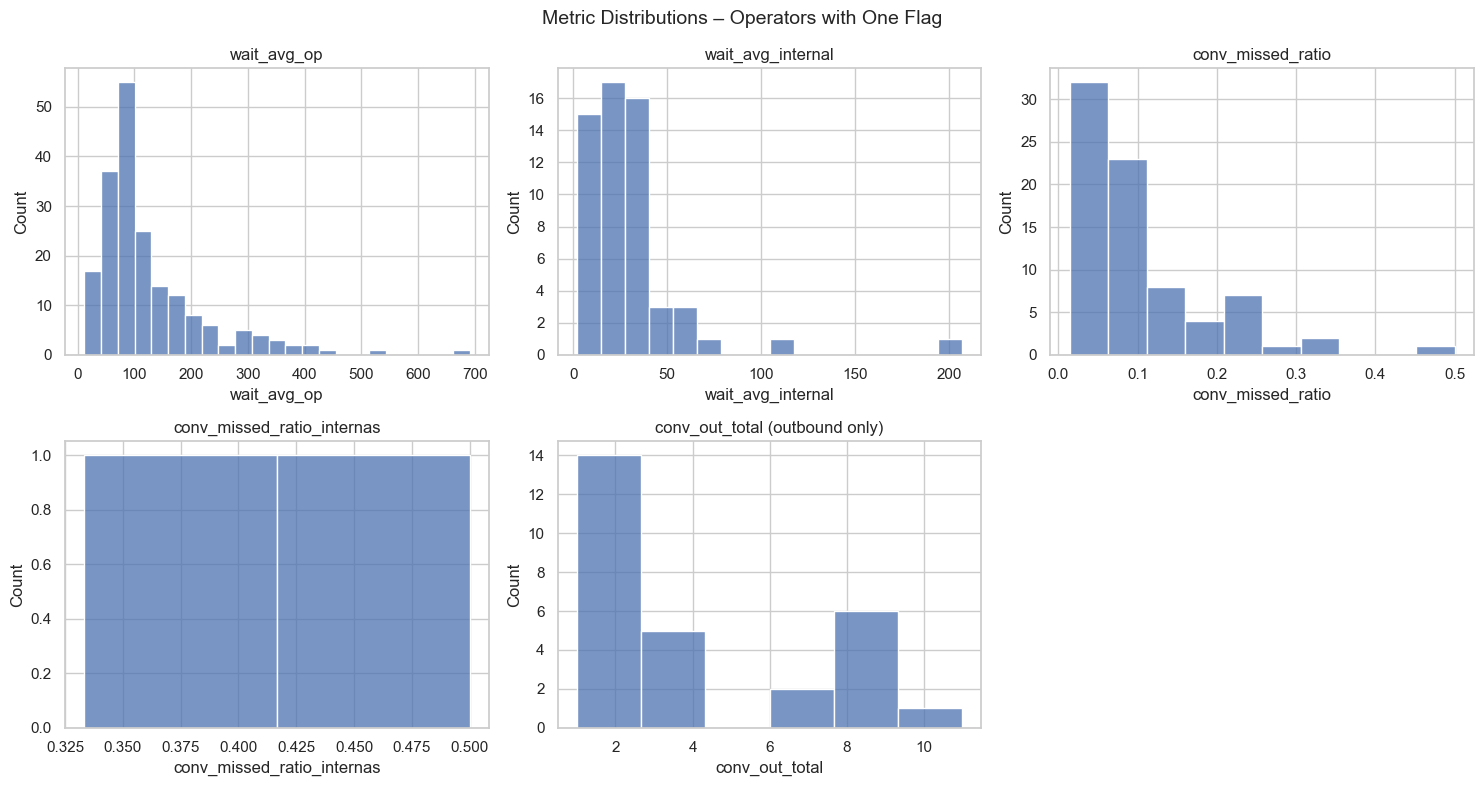

In [95]:
# ------------------------------------------------------------
# Analysis of operators with exactly 1 flag (borderline cases)
# ------------------------------------------------------------
# This subset represents operators showing a single signal
# of potential inefficiency.
# The goal is to understand whether these signals reflect:
# - Isolated cases
# - Values close to decision thresholds
# - Patterns that warrant monitoring rather than immediate action
# ------------------------------------------------------------

# Subset of operators with exactly one inefficiency flag
df_1_flag = df_ops[df_ops['num_flags'] == 1]

# Create a grid of distributions to inspect borderline behavior
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Metric Distributions – Operators with One Flag', fontsize=14)

# Average external waiting time
sns.histplot(df_1_flag['wait_avg_op'].dropna(), ax=axs[0, 0])
axs[0, 0].set_title('wait_avg_op')

# Average internal waiting time
sns.histplot(df_1_flag['wait_avg_internal'].dropna(), ax=axs[0, 1])
axs[0, 1].set_title('wait_avg_internal')

# Ratio of missed external conversations
sns.histplot(df_1_flag['conv_missed_ratio'].dropna(), ax=axs[0, 2])
axs[0, 2].set_title('conv_missed_ratio')

# Ratio of missed internal conversations
sns.histplot(df_1_flag['conv_missed_ratio_internas'].dropna(), ax=axs[1, 0])
axs[1, 0].set_title('conv_missed_ratio_internas')

# Outbound conversation volume (applies only to outbound operators)
sns.histplot(
    df_1_flag[df_1_flag['op_type'] == "outbound"]['conv_out_total'].dropna(),
    ax=axs[1, 1]
)
axs[1, 1].set_title('conv_out_total (outbound only)')

# Empty cell to keep grid layout balanced
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [96]:
# ------------------------------------------------------------
# Escalation step: extreme cases among operators with 1 flag
# ------------------------------------------------------------
# This step identifies operators that triggered ONLY ONE
# inefficiency flag, but whose raw metrics are so extreme
# that they should be escalated directly to "inefficient".
#
# IMPORTANT:
# - These are NOT borderline cases
# - These operators will be added to the inefficient group
#   in the next step
# - Borderline operators will be defined later using
#   softer, monitoring-oriented rules
# ------------------------------------------------------------

# Subset of operators with exactly one inefficiency flag
df_1_flag = df_ops[df_ops['num_flags'] == 1].copy()

# --- Extreme conditions ---
# Extremely high average external waiting time
cond1 = df_1_flag['wait_avg_op'] > 400

# Extremely high average internal waiting time
cond2 = df_1_flag['wait_avg_internal'] > 100

# High missed external conversation ratio
cond3 = df_1_flag['conv_missed_ratio'] > 0.20

# Any missed internal conversations present
cond4 = df_1_flag['conv_missed_ratio_internas'].notna()

# Outbound operators with critically low outbound volume
cond5 = df_1_flag['flag_low_outbound_conv_total'] == True

# Combine escalation conditions
df_1_flag_extremes = df_1_flag[cond1 | cond2 | cond3 | cond4 | cond5]

# --- Results ---
print(f"Operators with 1 flag escalated due to extreme behavior: {len(df_1_flag_extremes)}")

display(df_1_flag_extremes.head(10))

# Inspect outbound operators within this escalated group
df_1_flag_extremes.query('op_type == "outbound"').head()

Operators with 1 flag escalated due to extreme behavior: 24


,operator_id,wait_avg_op,wait_avg_internal,conv_missed_ratio,conv_missed_ratio_internas,conv_out_total,op_type,calls_count_total,outbound_calls_avg,flag_low_outbound_conv_total,flag_low_outbound_calls_avg,flag_low_outbound_calls_total,flag_wait_avg_op,flag_wait_avg_internal,flag_conv_missed_ratio,flag_conv_missed_ratio_internas,num_flags,is_inefficient
147,897872,21.666667,<NA>,0.333333,NaN,23.0,mixed,NaN,NaN,False,False,False,False,<NA>,True,False,1,False
278,906406,404.266667,<NA>,0.021739,NaN,82.0,mixed,NaN,NaN,False,False,False,True,<NA>,False,False,1,False
315,908300,57.0,112.0,NaN,NaN,NaN,unknown,NaN,NaN,False,False,False,False,True,False,False,1,False
325,909452,<NA>,<NA>,NaN,NaN,1.0,outbound,8.0,8.0,True,False,False,<NA>,<NA>,False,False,1,False
384,914440,31.352941,20.0,NaN,0.5,NaN,unknown,NaN,NaN,False,False,False,False,False,False,True,1,False
437,919204,303.083333,<NA>,0.235294,NaN,7.0,inbound,NaN,NaN,False,False,False,True,<NA>,False,False,1,False
438,919206,318.941176,<NA>,0.210526,NaN,1.0,inbound,NaN,NaN,False,False,False,True,<NA>,False,False,1,False
458,919504,<NA>,<NA>,NaN,NaN,1.0,outbound,28.0,28.0,True,False,False,<NA>,<NA>,False,False,1,False
460,919552,515.183333,<NA>,NaN,NaN,39.0,mixed,NaN,NaN,False,False,False,True,<NA>,False,False,1,False
461,919554,453.333333,<NA>,NaN,NaN,6.0,inbound,NaN,NaN,False,False,False,True,<NA>,False,False,1,False


,operator_id,wait_avg_op,wait_avg_internal,conv_missed_ratio,conv_missed_ratio_internas,conv_out_total,op_type,calls_count_total,outbound_calls_avg,flag_low_outbound_conv_total,flag_low_outbound_calls_avg,flag_low_outbound_calls_total,flag_wait_avg_op,flag_wait_avg_internal,flag_conv_missed_ratio,flag_conv_missed_ratio_internas,num_flags,is_inefficient
325,909452,<NA>,<NA>,NaN,NaN,1.0,outbound,8.0,8.0,True,False,False,<NA>,<NA>,False,False,1,False
458,919504,<NA>,<NA>,NaN,NaN,1.0,outbound,28.0,28.0,True,False,False,<NA>,<NA>,False,False,1,False
569,928518,<NA>,<NA>,NaN,NaN,1.0,outbound,25.0,25.0,True,False,False,<NA>,<NA>,False,False,1,False
728,938078,<NA>,<NA>,NaN,NaN,1.0,outbound,26.0,26.0,True,False,False,<NA>,<NA>,False,False,1,False


### 🔍 Impact of Outlier Refinement on Extreme 1-Flag Cases

After refining the treatment of outliers in waiting-time metrics (`wait_avg_op` and `wait_avg_internal`), a **substantial change** was observed in the number of operators with a single flag classified as extreme cases.

- **Before refinement:** 40 operators  
- **After refinement:** **24 operators**

This ~40% reduction indicates that many previously escalated cases were driven by **outlier-driven distortion**, such as inflated averages caused by a small number of extreme conversations.

Importantly, no classification rules or thresholds were changed. The improvement comes solely from **cleaning the metric inputs**, ensuring that inefficiency signals reflect **persistent behavioral patterns rather than isolated anomalies**.

As a result, the remaining operators in this subset exhibit **clear structural issues**, including:
- High missed-conversation ratios,
- Consistently long waiting times,
- Misalignment with expected operational roles (e.g., outbound operators with minimal activity).

This refinement increases the robustness of the classification system and **reduces false positives**, providing a more reliable foundation for final inefficiency labeling and the definition of *borderline* operators.

In [97]:
# ------------------------------------------------------------
# Escalate extreme 1-flag cases into the inefficient group
# ------------------------------------------------------------
# Build the final set of inefficient operators:
# - Operators already flagged as inefficient (>= 2 flags)
# - Operators with 1 flag but extreme behavior
operadores_inneficientes_total = (
    set(df_ops[df_ops['is_inefficient']]['operator_id']) |
    set(df_1_flag_extremes['operator_id'])
)

# Reassign the inefficiency label based on the extended set
df_ops['is_inefficient'] = df_ops['operator_id'].isin(operadores_inneficientes_total)

# ------------------------------------------------------------
# Final inefficient operators subset
# ------------------------------------------------------------
df_inneficientes = df_ops[df_ops['is_inefficient']].copy()

# Sanity check: total number of inefficient operators
print(
    f"Total number of inefficient operators (extended): "
    f"{df_ops[df_ops['is_inefficient']]['operator_id'].nunique()}"
)

Total number of inefficient operators (extended): 114


In [98]:
# ------------------------------------------------------------
# Threshold audit for outbound-related escalation rules
# ------------------------------------------------------------

print(f"Threshold used for outbound_calls_avg (Q1): {threshold_calls_avg}")
print(f"Threshold used for calls_count_total (P30): {threshold_calls_total}")
print(f"Threshold used for conv_out_total (Q1): {threshold_conv_out_total}")

# Inspect outbound operators with 1 flag
display(df_1_flag.query('op_type == "outbound"').head())

print(
    f"20th percentile of conv_out_total among 1-flag operators: "
    f"{df_1_flag['conv_out_total'].quantile(0.20):.1f}"
)

Threshold used for outbound_calls_avg (Q1): 2.0
Threshold used for calls_count_total (P30): 8.0
Threshold used for conv_out_total (Q1): 2.0


,operator_id,wait_avg_op,wait_avg_internal,conv_missed_ratio,conv_missed_ratio_internas,conv_out_total,op_type,calls_count_total,outbound_calls_avg,flag_low_outbound_conv_total,flag_low_outbound_calls_avg,flag_low_outbound_calls_total,flag_wait_avg_op,flag_wait_avg_internal,flag_conv_missed_ratio,flag_conv_missed_ratio_internas,num_flags,is_inefficient
35,887280,<NA>,<NA>,NaN,NaN,6.0,outbound,8.0,1.333333,False,True,False,<NA>,<NA>,False,False,1,False
68,891156,<NA>,<NA>,NaN,NaN,11.0,outbound,18.0,1.636364,False,True,False,<NA>,<NA>,False,False,1,False
107,893700,<NA>,<NA>,NaN,NaN,3.0,outbound,6.0,2.000000,False,False,True,<NA>,<NA>,False,False,1,False
111,894226,<NA>,<NA>,NaN,NaN,2.0,outbound,4.0,2.000000,False,False,True,<NA>,<NA>,False,False,1,False
325,909452,<NA>,<NA>,NaN,NaN,1.0,outbound,8.0,8.000000,True,False,False,<NA>,<NA>,False,False,1,False


20th percentile of conv_out_total among 1-flag operators: 3.4


In [99]:
# ------------------------------------------------------------
# Identification of BORDERLINE operators
# ------------------------------------------------------------
# Borderline operators are defined as:
# - Having exactly ONE inefficiency flag
# - NOT previously escalated as inefficient
# - NOT showing extreme metric values
#
# These operators do not require immediate action,
# but should be monitored closely for potential deterioration.
# ------------------------------------------------------------

# Operators with exactly 1 flag and not classified as inefficient
df_1_flag = df_ops[
    (df_ops['num_flags'] == 1) &
    (df_ops['is_inefficient'] == False)
].copy()

# Extreme behavior thresholds (already escalated earlier)
cond_extreme = (
    (df_1_flag['wait_avg_op'] > 400) |
    (df_1_flag['wait_avg_internal'] > 100) |
    (df_1_flag['conv_missed_ratio'] > 0.20) |
    (df_1_flag['conv_missed_ratio_internas'] > 0.20)
)

# Outbound-specific borderline condition:
# Operators with low but non-zero outbound activity
df_outbound_borderline = df_ops[
    (df_ops['op_type'] == 'outbound') &
    (df_ops['is_inefficient'] == False) &
    (df_ops['conv_out_total'].between(3, 7, inclusive='both'))
].copy()

# Borderline operators:
# - Exactly one flag
# - No extreme behavior
df_borderline = df_1_flag[~cond_extreme].copy()

# Include outbound borderline cases
df_borderline = pd.concat([df_borderline, df_outbound_borderline], ignore_index=True)

# Remove potential duplicates
df_borderline = df_borderline.drop_duplicates(subset='operator_id')

# Summary output
print(f"Total borderline operators identified: {len(df_borderline)}")

display(
    df_borderline[['operator_id', 'op_type', 'num_flags', 'outbound_calls_avg'] + flag_cols]
    .head(10)
)

print("\nOutbound borderline operators:")
display(df_borderline.query('op_type == "outbound"').head())

Total borderline operators identified: 110


,operator_id,op_type,num_flags,outbound_calls_avg,flag_low_outbound_conv_total,flag_low_outbound_calls_avg,flag_low_outbound_calls_total,flag_wait_avg_op,flag_wait_avg_internal,flag_conv_missed_ratio,flag_conv_missed_ratio_internas
0,882478,unknown,1,NaN,False,False,False,False,True,False,False
1,893420,inbound,1,NaN,False,False,False,True,False,False,False
2,893804,mixed,1,NaN,False,False,False,True,False,False,False
3,901178,inbound,1,NaN,False,False,False,True,False,False,False
4,901880,mixed,1,NaN,False,False,False,True,False,False,False
5,901884,mixed,1,NaN,False,False,False,True,False,False,False
6,903512,unknown,1,NaN,False,False,False,True,False,False,False
7,906680,mixed,1,NaN,False,False,False,True,False,False,False
8,908958,mixed,1,NaN,False,False,False,True,False,False,False
9,908960,mixed,1,NaN,False,False,False,True,False,False,False



Outbound borderline operators:


,operator_id,wait_avg_op,wait_avg_internal,conv_missed_ratio,conv_missed_ratio_internas,conv_out_total,op_type,calls_count_total,outbound_calls_avg,flag_low_outbound_conv_total,flag_low_outbound_calls_avg,flag_low_outbound_calls_total,flag_wait_avg_op,flag_wait_avg_internal,flag_conv_missed_ratio,flag_conv_missed_ratio_internas,num_flags,is_inefficient
50,880240,<NA>,<NA>,NaN,NaN,7.0,outbound,41.0,5.857143,False,False,False,<NA>,<NA>,False,False,0,False
51,881278,<NA>,<NA>,NaN,NaN,5.0,outbound,12.0,2.400000,False,False,False,<NA>,<NA>,False,False,0,False
52,887280,<NA>,<NA>,NaN,NaN,6.0,outbound,8.0,1.333333,False,True,False,<NA>,<NA>,False,False,1,False
53,887992,<NA>,<NA>,NaN,NaN,6.0,outbound,47.0,7.833333,False,False,False,<NA>,<NA>,False,False,0,False
54,891746,<NA>,<NA>,NaN,NaN,5.0,outbound,33.0,6.600000,False,False,False,<NA>,<NA>,False,False,0,False


In [100]:
# ------------------------------------------------------------
# Re-attach key operator-level metrics to borderline operators
# ------------------------------------------------------------
# Goal:
# Borderline operators were identified using logical rules and flags.
# At this stage, we explicitly re-merge the original operator-level
# metrics to:
# - avoid duplicated columns (_x / _y)
# - ensure we are inspecting the final, authoritative values
# - allow transparent inspection and reporting
# ------------------------------------------------------------

# List of key metrics to retrieve from the master operator table
key_metrics = [
    'operator_id',
    'wait_avg_op',
    'wait_avg_internal',
    'conv_missed_ratio',
    'conv_missed_ratio_internas',
    'conv_out_total',
    'outbound_calls_avg',
    'calls_count_total'
]

# Create a safe copy of the borderline operators table
df_borderline_metrics = df_borderline.copy()

# Remove any existing versions of these metrics to prevent column conflicts
for col in key_metrics:
    if col in df_borderline_metrics.columns and col != 'operator_id':
        df_borderline_metrics.drop(columns=col, inplace=True)

# Clean merge with the master operator-level dataframe
df_borderline_metrics = df_borderline_metrics.merge(
    df_ops[key_metrics],
    on='operator_id',
    how='left'
)

# ------------------------------------------------------------
# Inspect metrics for all borderline operators
# ------------------------------------------------------------
display(
    df_borderline_metrics[
        ['operator_id', 'op_type', 'num_flags'] + key_metrics[1:6]
    ].head(10)
)

# ------------------------------------------------------------
# Inspect outbound borderline operators specifically
# ------------------------------------------------------------
display(
    df_borderline_metrics
    .query('op_type == "outbound"')[
        ['operator_id', 'op_type', 'num_flags'] + key_metrics[5:]
    ].head(10)
)

,operator_id,op_type,num_flags,wait_avg_op,wait_avg_internal,conv_missed_ratio,conv_missed_ratio_internas,conv_out_total
0,882478,unknown,1,13.0,63.0,NaN,NaN,NaN
1,893420,inbound,1,86.6875,20.0,0.020833,NaN,20.0
2,893804,mixed,1,121.833333,6.2,0.058824,NaN,150.0
3,901178,inbound,1,98.0,3.75,NaN,NaN,11.0
4,901880,mixed,1,96.20202,4.888889,0.101010,NaN,167.0
5,901884,mixed,1,87.523256,16.555556,NaN,NaN,167.0
6,903512,unknown,1,78.928571,28.333333,NaN,NaN,NaN
7,906680,mixed,1,134.169811,29.0,NaN,NaN,54.0
8,908958,mixed,1,299.56962,21.307692,NaN,NaN,42.0
9,908960,mixed,1,182.802326,24.681818,0.058140,NaN,50.0


,operator_id,op_type,num_flags,conv_out_total,outbound_calls_avg,calls_count_total
50,880240,outbound,0,7.0,5.857143,41.0
51,881278,outbound,0,5.0,2.400000,12.0
52,887280,outbound,1,6.0,1.333333,8.0
53,887992,outbound,0,6.0,7.833333,47.0
54,891746,outbound,0,5.0,6.600000,33.0
55,892800,outbound,0,3.0,2.666667,8.0
56,893700,outbound,1,3.0,2.000000,6.0
57,894934,outbound,0,3.0,6.333333,19.0
58,896384,outbound,0,3.0,9.333333,28.0
59,897894,outbound,0,5.0,3.800000,19.0


## Exploratory Data Analysis (EDA) – Key Conclusions

During this exploratory analysis, multiple operator-level metrics were evaluated to understand performance patterns, detect anomalies, and systematically classify operators based on efficiency. The main findings are summarized below.

### 1. Outlier Detection and Initial Adjustments
Several extreme values were identified in variables such as `call_duration`, `waiting_time_ttl`, and `calls_count`, mainly driven by long conversations or sessions with multiple calls.  
These values were considered **operationally valid**, as they reflect real call-center scenarios.  
To avoid distortion while preserving realistic behavior, a **targeted outlier filter based on `calls_count`** was applied, removing only the most extreme cases.

### 2. Operator-Level Metrics
After cleaning, key metrics were aggregated at the operator level, including:
- Average waiting times (`wait_avg_op`, `wait_avg_internal`)
- Missed conversation ratios (`conv_missed_ratio`, `conv_missed_ratio_internas`)
- Outbound activity volume (`conv_out_total`)

While many operators showed acceptable performance, the distributions exhibited high dispersion, motivating the use of **operator-type–aware thresholds**.

### 3. Inefficiency Rules and Flagging
Multiple inefficiency flags were defined using percentile-based and rule-based thresholds:
- High waiting times (global P75)
- High missed conversation ratios (>30%)
- Low outbound activity for outbound operators (Q1-based thresholds)

Operators accumulating **two or more flags** were classified as *inefficient*, resulting in **90 operators** initially identified.

### 4. Escalation of Extreme One-Flag Cases
A subset of operators showed **only one flag but extreme behavior**, such as:
- `wait_avg_op > 400`
- `wait_avg_internal > 100`
- `conv_missed_ratio > 20%`

To avoid underestimating risk, **24 of these operators** were escalated and reclassified as inefficient, bringing the total to **114 inefficient operators**.

### 5. Borderline Operators
A separate *borderline* group was defined to capture operators with:
- Exactly one inefficiency flag, without extreme values
- Outbound operators with moderately low outbound volumes (`conv_out_total` between 3 and 7)

This group includes **110 operators** who are not currently inefficient but should be monitored due to proximity to risk thresholds.

### 6. Final Observations
- Inefficient operators consistently show higher waiting times, higher abandonment ratios, and lower activity levels.
- Borderline operators exhibit more balanced metrics but remain close to critical thresholds.
- The combined approach (flags + extreme-case escalation + borderline monitoring) provides a robust and interpretable classification framework.

---

### Final Reflection

This EDA establishes a **proactive, data-driven operator monitoring system** that:
- Preserves realistic operational variability
- Avoids arbitrary exclusions
- Adapts to different operator roles
- Enables early intervention before performance degradation becomes critical

The resulting framework serves as a strong foundation for downstream statistical testing and operational decision-making.

## Statistical Validation Design for Operational Inefficiency

To validate that the classification of inefficient operators is statistically grounded, we perform hypothesis testing to directly compare their key performance metrics against those of efficient operators. The goal is to confirm the presence of **consistent and statistically significant numerical differences** that support the rule-based labeling strategy.

Although multiple subgroup comparisons were initially considered, the final validation strategy is intentionally simplified to focus on **two core comparisons**, using **non-parametric tests (Mann–Whitney U)** with **one-sided alternative hypotheses** aligned with expected operational behavior.

This approach ensures robustness while avoiding unnecessary multiple-comparison complexity.

### Statistical Test Summary

| Comparison                 | Operator Group        | Key Metrics                                                   | Variable Type        | Test Used          | Alternative Hypothesis                                |
|---------------------------|-----------------------|----------------------------------------------------------------|----------------------|--------------------|------------------------------------------------------|
| Inefficient vs Efficient  | Non-outbound operators | `wait_avg_op`, `wait_avg_internal`, `conv_missed_ratio`       | Continuous numeric   | Mann–Whitney U     | Inefficient operators have higher values             |
| Inefficient vs Efficient  | Outbound operators     | `conv_out_total`, `calls_count_total`, `outbound_calls_avg`   | Continuous numeric   | Mann–Whitney U     | Inefficient operators have lower values              |

### Rationale

- **Non-outbound operators** are evaluated using efficiency and service-quality metrics (waiting times and missed conversation ratios), which directly reflect responsiveness and operational load.
- **Outbound operators** follow a different operational role; therefore, validation focuses on **activity volume metrics**, where lower values indicate underperformance.

These tests allow us to verify that the rule-based inefficiency labels correspond to **statistically meaningful behavioral differences**, strengthening confidence in the overall classification framework.

In [101]:
# ------------------------------------------------------------
# Statistical validation using Mann–Whitney U tests
# ------------------------------------------------------------
# Direction of the test is aligned with operational expectations:
# - Efficiency metrics: higher values = worse performance
# - Outbound activity metrics: lower values = worse performance
# ------------------------------------------------------------

metrics_no_outbound = ['wait_avg_op', 'wait_avg_internal', 'conv_missed_ratio']
metrics_outbound = ['conv_out_total', 'calls_count_total', 'outbound_calls_avg']

# Alternative hypothesis mapping
# 'less'    → efficient < inefficient (inefficient has higher values)
# 'greater' → efficient > inefficient (inefficient has lower values)
alternatives = {
    'wait_avg_op': 'less',
    'wait_avg_internal': 'less',
    'conv_missed_ratio': 'less',
    'conv_out_total': 'greater',
    'calls_count_total': 'greater',
    'outbound_calls_avg': 'greater',
}

def run_mannwhitney_tests(df, metrics, group_label):
    results = []
    efficient = df[df['is_inefficient'] == False]
    inefficient = df[df['is_inefficient'] == True]

    for metric in metrics:
        x = pd.to_numeric(efficient[metric], errors='coerce').dropna().astype(float)
        y = pd.to_numeric(inefficient[metric], errors='coerce').dropna().astype(float)

        if len(x) > 5 and len(y) > 5:
            stat, p_value = mannwhitneyu(x, y, alternative=alternatives[metric])

            results.append({
                'group': group_label,
                'metric': metric,
                'n_efficient': len(x),
                'n_inefficient': len(y),
                'median_efficient': round(x.median(), 2),
                'median_inefficient': round(y.median(), 2),
                'alternative': alternatives[metric],
                'p_value': p_value
            })

    return results


# Split datasets by operator type
df_no_outbound = df_ops[df_ops['op_type'] != 'outbound']
df_outbound = df_ops[df_ops['op_type'] == 'outbound']

# Run tests
results_no_outbound = run_mannwhitney_tests(df_no_outbound, metrics_no_outbound, 'non_outbound')
results_outbound = run_mannwhitney_tests(df_outbound, metrics_outbound, 'outbound')

# Consolidate results
df_results = pd.DataFrame(results_no_outbound + results_outbound)

# Round p-values for display, but keep raw p-values in df_results if you need them later
df_results_display = df_results.copy()
df_results_display['p_value'] = df_results_display['p_value'].apply(lambda p: "< 0.001" if p < 0.001 else round(p, 4))

display(df_results_display)


# ------------------------------------------------------------
# Pretty printed summary (auto-generated from df_results)
# ------------------------------------------------------------
print("\n🔍 Statistical validation of inefficient operator classification")
print("=" * 72)

# Test 1: Non-outbound
print("\n📊 Test 1: NON-outbound operators")
print("H₀: No significant differences. Metric distributions are the same between efficient and inefficient operators.")
print("H₁: Inefficient operators have higher (worse) values in key efficiency metrics.\n")
print("Results:")

tmp = df_results_display[df_results_display['group'] == 'non_outbound']
for _, r in tmp.iterrows():
    print(f"- {r['metric']} → median inefficient: {r['median_inefficient']} vs efficient: {r['median_efficient']} → p-value: {r['p_value']}")

# Test 2: Outbound
print("\n📊 Test 2: OUTBOUND operators")
print("H₀: No significant differences. Metric distributions are the same between efficient and inefficient operators.")
print("H₁: Inefficient operators have lower outbound activity (lower values) in key outbound metrics.\n")
print("Results:")

tmp = df_results_display[df_results_display['group'] == 'outbound']
for _, r in tmp.iterrows():
    print(f"- {r['metric']} → median inefficient: {r['median_inefficient']} vs efficient: {r['median_efficient']} → p-value: {r['p_value']}")

print("\n✅ Conclusion: The null hypothesis is rejected for all tested metrics (p < 0.05, typically p < 0.001).")
print("   Differences are statistically significant and consistent with the classification logic.")

,group,metric,n_efficient,n_inefficient,median_efficient,median_inefficient,alternative,p_value
0,non_outbound,wait_avg_op,701,37,30.75,75.38,less,< 0.001
1,non_outbound,wait_avg_internal,120,20,16.78,44.00,less,< 0.001
2,non_outbound,conv_missed_ratio,143,21,0.07,0.22,less,< 0.001
3,outbound,conv_out_total,232,77,11.00,1.00,greater,< 0.001
4,outbound,calls_count_total,228,77,65.50,2.00,greater,< 0.001
5,outbound,outbound_calls_avg,228,77,8.37,1.00,greater,< 0.001



🔍 Statistical validation of inefficient operator classification

📊 Test 1: NON-outbound operators
H₀: No significant differences. Metric distributions are the same between efficient and inefficient operators.
H₁: Inefficient operators have higher (worse) values in key efficiency metrics.

Results:
- wait_avg_op → median inefficient: 75.38 vs efficient: 30.75 → p-value: < 0.001
- wait_avg_internal → median inefficient: 44.0 vs efficient: 16.78 → p-value: < 0.001
- conv_missed_ratio → median inefficient: 0.22 vs efficient: 0.07 → p-value: < 0.001

📊 Test 2: OUTBOUND operators
H₀: No significant differences. Metric distributions are the same between efficient and inefficient operators.
H₁: Inefficient operators have lower outbound activity (lower values) in key outbound metrics.

Results:
- conv_out_total → median inefficient: 1.0 vs efficient: 11.0 → p-value: < 0.001
- calls_count_total → median inefficient: 2.0 vs efficient: 65.5 → p-value: < 0.001
- outbound_calls_avg → median ineffic

## Final Tableau Dashboard Plan

This dashboard is designed to present **clear, interactive, and actionable insights** into operator performance, highlighting the differences between **efficient, inefficient, and borderline operators** using the metrics validated through statistical testing.

### Dashboard Objectives

- Clearly visualize performance differences across operator groups  
- Enable focused exploration of **borderline operators**  
- Prioritize the most **business-relevant and statistically validated metrics**  
- Provide interactive filters to support operational decision-making  

---

### Selected Key Metrics

#### For *non-outbound* operators:
- `wait_avg_op` — average external waiting time  
- `wait_avg_internal` — average internal waiting time  
- `conv_missed_ratio` — proportion of missed external conversations  

#### For *outbound* operators:
- `conv_out_total` — total outbound external conversations  
- `calls_count_total` — total outbound call volume  
- `outbound_calls_avg` — average outbound calls per day  

---

### Planned Visualizations

| Visualization | Chart Type | Interactivity | Purpose |
|--------------|------------|---------------|---------|
| **Median comparison by operator group** | Grouped bar chart | Filter by operator type | Highlight statistically significant performance differences between efficient, inefficient, and borderline operators. |
| **Metric distributions by operator** | Horizontal bar charts | Filter by group | Identify outliers and extreme cases within each performance metric. |
| **Borderline operators table** | Interactive table | Filter by metric | Quickly inspect operators close to inefficiency thresholds and understand which metrics drive risk. |
| **Calls heatmap (weekday × month)** | Heatmap | Filter by operator type | Reveal temporal workload patterns and potential operational stress periods. |

> 📌 *All visualizations are implemented in Tableau with interactive filters and allow drilling down to individual operators for deeper analysis.*

In [107]:
# ------------------------------------------------------------
# Plotly — Separate median comparison charts:
# 1) Non-outbound operators: "more is worse" metrics
# 2) Outbound operators: "less is worse" volume metrics
#
# Why? Outbound operators typically have NA for inbound metrics (wait/missed),
# so mixing everything in one chart becomes misleading.
# ------------------------------------------------------------

# -----------------------------
# Helper: build non-overlapping groups
# (remove borderline IDs from Efficient & Inefficient pools)
# -----------------------------
borderline_ids = set(df_borderline['operator_id'])

df_ineff_base = df_ops[df_ops['is_inefficient'] == True].copy()
df_ineff_base = df_ineff_base[~df_ineff_base['operator_id'].isin(borderline_ids)]
df_ineff_base['group'] = 'Inefficient'

df_border = df_borderline.copy()
df_border['group'] = 'Borderline'

df_eff_base = df_ops[df_ops['is_inefficient'] == False].copy()
df_eff_base = df_eff_base[~df_eff_base['operator_id'].isin(borderline_ids)]
df_eff_base['group'] = 'Efficient'

# Combine once (no duplicates)
df_all = pd.concat([df_eff_base, df_ineff_base, df_border], ignore_index=True)

# Consistent group order
group_order = ['Efficient', 'Borderline', 'Inefficient']

# Color map (keep your palette)
color_map = {
    'Efficient': '#1f77b4',
    'Inefficient': '#d62728',
    'Borderline': '#ff7f0e'
}

# ============================================================
# 1) NON-OUTBOUND chart (inbound / service metrics)
# ============================================================
metrics_non_outbound = ['wait_avg_op', 'wait_avg_internal', 'conv_missed_ratio']

df_non_out = df_all[df_all['op_type'] != 'outbound'].copy()

# Medians per group
med_non_out = (
    df_non_out
    .groupby('group')[metrics_non_outbound]
    .median(numeric_only=True)
    .reindex(group_order)  # order rows
    .reset_index()
)

# Long format
long_non_out = med_non_out.melt(id_vars='group', var_name='Metric', value_name='Median')
long_non_out['Median'] = pd.to_numeric(long_non_out['Median'], errors='coerce').round(2)

# Preserve metric order on x-axis
metric_order_non_out = {m: i for i, m in enumerate(metrics_non_outbound)}
long_non_out['ord'] = long_non_out['Metric'].map(metric_order_non_out)
long_non_out = long_non_out.sort_values(['ord', 'group']).drop(columns='ord')

fig_non_out = px.bar(
    long_non_out,
    x='Metric',
    y='Median',
    color='group',
    barmode='group',
    text='Median',
    color_discrete_map=color_map,
    category_orders={'group': group_order},
    labels={'group': 'Group', 'Median': 'Median value'},
    title='Median Comparison (Non-outbound operators): Wait & Missed Metrics'
)

fig_non_out.update_traces(textposition='outside')
fig_non_out.update_layout(
    xaxis_tickangle=-20,
    xaxis=dict(title="Metric", title_font=dict(size=18), tickfont=dict(size=14)),
    yaxis=dict(title="Median value", title_font=dict(size=18), tickfont=dict(size=13)),
    height=560,
    title_font_size=20,
    legend_title_text="Group"
)

fig_non_out.show()

# ============================================================
# 2) OUTBOUND chart (volume/activity metrics)
# ============================================================
metrics_outbound = ['conv_out_total', 'calls_count_total', 'outbound_calls_avg']

df_out = df_all[df_all['op_type'] == 'outbound'].copy()

# Medians per group
med_out = (
    df_out
    .groupby('group')[metrics_outbound]
    .median(numeric_only=True)
    .reindex(group_order)  # order rows
    .reset_index()
)

# Long format
long_out = med_out.melt(id_vars='group', var_name='Metric', value_name='Median')
long_out['Median'] = pd.to_numeric(long_out['Median'], errors='coerce').round(2)

# Preserve metric order on x-axis
metric_order_out = {m: i for i, m in enumerate(metrics_outbound)}
long_out['ord'] = long_out['Metric'].map(metric_order_out)
long_out = long_out.sort_values(['ord', 'group']).drop(columns='ord')

fig_out = px.bar(
    long_out,
    x='Metric',
    y='Median',
    color='group',
    barmode='group',
    text='Median',
    color_discrete_map=color_map,
    category_orders={'group': group_order},
    labels={'group': 'Group', 'Median': 'Median value'},
    title='Median Comparison (Outbound operators): Volume & Activity Metrics'
)

fig_out.update_traces(textposition='outside')
fig_out.update_layout(
    xaxis_tickangle=-20,
    xaxis=dict(title="Metric", title_font=dict(size=18), tickfont=dict(size=14)),
    yaxis=dict(title="Median value", title_font=dict(size=18), tickfont=dict(size=13)),
    height=560,
    title_font_size=20,
    legend_title_text="Group"
)

fig_out.show()

In [112]:
# ------------------------------------------------------------
# Violin plots by group (Efficient / Inefficient / Borderline)
# Fixes:
# 1) Ensure color_map keys match df_violin['grupo'] labels
# 2) Remove borderline operators from Efficient/Inefficient pools (no duplicates)
# 3) Coerce metrics to numeric and drop NaNs per trace
# ------------------------------------------------------------

# Key metrics to display
metricas_violin = [
    'wait_avg_op',
    'conv_missed_ratio',
    'conv_out_total',
    'calls_count_total'
]

# Descriptive names
nombres_metricas = {
    "wait_avg_op": "Average external waiting time per operator (seconds)",
    "conv_missed_ratio": "Missed inbound external conversation ratio",
    "conv_out_total": "Total outbound external conversations",
    "calls_count_total": "Total outbound calls (count)"
}

# IMPORTANT: make sure color_map matches the exact group labels we will use
color_map = {
    'Eficientes': '#1f77b4',
    'Ineficientes': '#d62728',
    'Borderline': '#ff7f0e'
}

# --- Build clean, non-overlapping groups ---
borderline_ids = set(df_borderline['operator_id'])

df_border = df_borderline.copy()
df_border['grupo'] = 'Borderline'

df_eff = df_ops[df_ops['is_inefficient'] == False].copy()
df_eff = df_eff[~df_eff['operator_id'].isin(borderline_ids)]
df_eff['grupo'] = 'Eficientes'

df_ineff = df_ops[df_ops['is_inefficient'] == True].copy()
df_ineff = df_ineff[~df_ineff['operator_id'].isin(borderline_ids)]
df_ineff['grupo'] = 'Ineficientes'

df_violin = pd.concat([df_eff, df_ineff, df_border], ignore_index=True)

# Keep only metrics that exist
metricas_violin = [m for m in metricas_violin if m in df_violin.columns]

# Replace pd.NA with np.nan + force numeric for plotting
df_violin = df_violin.replace({pd.NA: np.nan})
for m in metricas_violin:
    df_violin[m] = pd.to_numeric(df_violin[m], errors='coerce')

# --- Plot one violin per metric ---
for metrica in metricas_violin:
    fig = go.Figure()

    for grupo, color in color_map.items():
        datos = df_violin.loc[df_violin['grupo'] == grupo, metrica].dropna()

        fig.add_trace(
            go.Violin(
                y=datos,
                name=grupo,
                line_color=color,
                box_visible=True,
                meanline_visible=True,
                points='all',
                jitter=0.3,
                scalemode='count',
                marker=dict(opacity=0.5, size=4)
            )
        )

    fig.update_layout(
        title=nombres_metricas.get(metrica, metrica),
        yaxis_title=nombres_metricas.get(metrica, metrica),
        height=700,
        violinmode='group',
        showlegend=True
    )

    fig.show()

In [114]:
# ------------------------------------------------------------
# Interactive horizontal bar chart (Operator-level distribution)
# Robust version: single dropdown = Metric + Group
# ------------------------------------------------------------

metricas_finales = {
    "wait_avg_op": "Avg external waiting time (s)",
    "wait_avg_internal": "Avg internal transfer waiting time (s)",
    "conv_missed_ratio": "Missed inbound external ratio",
    "conv_out_total": "Total outbound external conversations",
    "calls_count_total": "Total outbound calls (count)",
    "outbound_calls_avg": "Avg outbound calls per conversation"
}

grupos = ["Eficientes", "Ineficientes", "Borderline"]

# Use the already-built df_todos (non-overlapping groups)
df_bar = df_todos.copy().replace({pd.NA: np.nan})

# Ensure numeric
for metrica in metricas_finales:
    if metrica in df_bar.columns:
        df_bar[metrica] = pd.to_numeric(df_bar[metrica], errors="coerce")

# Colors by group (consistent with previous charts)
color_map = {
    "Eficientes": "#1f77b4",
    "Ineficientes": "#d62728",
    "Borderline": "#ff7f0e",
}

fig = go.Figure()

# Build traces in a fixed order: metric -> group
trace_index = {}
k = 0
for metrica, nombre_metrica in metricas_finales.items():
    for grupo in grupos:
        df_g = (
            df_bar[df_bar["grupo"] == grupo]
            .dropna(subset=[metrica, "operator_id"])
            .sort_values(by=metrica, ascending=False)
        )

        fig.add_trace(
            go.Bar(
                x=df_g[metrica],
                y=df_g["operator_id"],
                orientation="h",
                marker=dict(color=color_map[grupo]),
                name=f"{grupo}",
                visible=(metrica == "wait_avg_op" and grupo == "Eficientes"),
            )
        )
        trace_index[(metrica, grupo)] = k
        k += 1

# Single dropdown: Metric + Group
dropdown = []
for metrica, nombre_metrica in metricas_finales.items():
    for grupo in grupos:
        visible = [False] * len(fig.data)
        visible[trace_index[(metrica, grupo)]] = True

        dropdown.append(
            dict(
                label=f"{nombre_metrica} — {grupo}",
                method="update",
                args=[
                    {"visible": visible},
                    {
                        "title": f"Operator distribution: {nombre_metrica} — {grupo}",
                        "xaxis": {"title": "Metric value"},
                        "yaxis": {"title": "Operator ID"},
                    },
                ],
            )
        )

fig.update_layout(
    title="Operator distribution: Avg external waiting time (s) — Eficientes",
    xaxis_title="Metric value",
    yaxis_title="Operator ID",
    height=750,
    template="plotly_dark",
    margin=dict(l=120, r=60, t=100, b=80),
    updatemenus=[
        dict(
            buttons=dropdown,
            direction="down",
            x=0.5,
            xanchor="center",
            y=0.95,
            yanchor="top",
            showactive=True,
            bgcolor="#333",
            font=dict(color="whitesmoke"),
            bordercolor="whitesmoke",
            borderwidth=1,
        )
    ],
)

fig.show()

In [116]:
# ------------------------------------------------------------
# Heatmap: conversations by weekday & month, faceted by group
# Stable ordering (months + weekdays) and exact counts
# ------------------------------------------------------------

# Merge conversations with operator group label
calls_merge = calls_filtered.merge(
    df_todos[["operator_id", "grupo"]].drop_duplicates("operator_id"),
    on="operator_id",
    how="left"
)

# Ensure datetime
calls_merge["date_no_tz"] = pd.to_datetime(calls_merge["date_no_tz"], errors="coerce")

# Build month as Period (keeps chronological ordering)
calls_merge["month_period"] = calls_merge["date_no_tz"].dt.to_period("M")
calls_merge["month"] = calls_merge["month_period"].astype(str)

# Weekday names (force English order via categories)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
calls_merge["weekday"] = calls_merge["date_no_tz"].dt.day_name()
calls_merge["weekday"] = pd.Categorical(calls_merge["weekday"], categories=weekday_order, ordered=True)

# Aggregate counts
llamadas_agrupadas = (
    calls_merge
    .dropna(subset=["month_period", "weekday", "grupo"])
    .groupby(["grupo", "month_period", "month", "weekday"])
    .size()
    .reset_index(name="num_llamadas")
)

# Sort months chronologically
llamadas_agrupadas = llamadas_agrupadas.sort_values(["grupo", "month_period", "weekday"])

# Build heatmap-ready matrix per group using px.imshow (exact values)
figs = []
for grupo in ["Eficientes", "Ineficientes", "Borderline"]:
    df_g = llamadas_agrupadas[llamadas_agrupadas["grupo"] == grupo].copy()

    pivot = (
        df_g.pivot_table(
            index="month",
            columns="weekday",
            values="num_llamadas",
            aggfunc="sum",
            fill_value=0
        )
        .reindex(columns=weekday_order)
    )

    # Ensure month rows stay chronological (use month_period order)
    month_order = (
        df_g[["month", "month_period"]]
        .drop_duplicates()
        .sort_values("month_period")["month"]
        .tolist()
    )
    pivot = pivot.reindex(index=month_order)

    figs.append(
        px.imshow(
            pivot,
            aspect="auto",
            labels=dict(x="Weekday", y="Month", color="Conversations"),
            title=f"Conversations heatmap — {grupo}",
        )
    )

# Combine as facets (3 subplots) using one figure is possible, but simplest is:
# show one by one in notebook (or export each for Tableau).
# If you prefer a single faceted figure, tell me and I’ll merge them.

for f in figs:
    f.update_layout(
        template="plotly_dark",
        height=520,
        font=dict(color="whitesmoke"),
        plot_bgcolor="#2a2a2a",
        paper_bgcolor="#2a2a2a",
        margin=dict(t=80, b=40, l=60, r=40)
    )
    f.show()

/var/folders/p1/6xjs3nrj1114kr5qgj0jm4cr0000gn/T/ipykernel_54398/716792728.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/p1/6xjs3nrj1114kr5qgj0jm4cr0000gn/T/ipykernel_54398/716792728.py:43: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/p1/6xjs3nrj1114kr5qgj0jm4cr0000gn/T/ipykernel_54398/716792728.py:43: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/p1/6xjs3nrj1114kr5qgj0jm4cr0000gn/T/ipykernel_54398/716792728.py:43: FutureWarning:

## Final Sprint Conclusion

The objective of this sprint was to evaluate operator-level performance, identify operational inefficiencies, and build a robust foundation for continuous monitoring supported by objective metrics and statistical validation.

---

### 🔧 Data Preprocessing and Enrichment

The project began with an extensive data cleaning and validation process, including duplicate removal, format standardization, logical consistency checks, and validation of temporal ranges.  
Afterwards, a set of derived metrics was constructed to capture operator performance from multiple perspectives, covering both inbound and outbound activity.

This preprocessing phase ensured that all subsequent analyses were based on reliable, coherent, and operationally meaningful data.

---

### 📊 Key Metrics Evaluated

#### **1. Metrics for non-outbound operators**

These metrics capture general operational efficiency:

- `wait_avg_op` — Average customer waiting time.  
- `wait_avg_internal` — Waiting time during internal transfers.  
- `conv_missed_ratio` — Proportion of missed external conversations.  
- `conv_missed_ratio_internas` — Proportion of missed internal conversations.  
- `calls_count_total` — Total number of handled calls.

#### **2. Shared metric across all operators**

- `conv_out_total` — Total number of outbound conversations handled.

#### **3. Outbound-specific metrics**

- `calls_out_total` — Total outbound calls placed.  
- `outbound_calls_avg` — Average daily outbound call volume.

---

### 🧩 Operator Classification Framework

Operators were segmented using a rule-based system built on distribution percentiles and expected operational behavior:

- **Efficient:** Stable performance with favorable metric values.  
- **Inefficient:** Persistent underperformance across multiple indicators.  
- **Borderline:** Near critical thresholds, representing potential operational risk.

This structure allows both immediate intervention and proactive monitoring.

---

### 🔬 Statistical Validation

To validate the classification logic, non-parametric **Mann–Whitney U tests** were applied:

- Inefficient operators showed significantly higher waiting times and higher missed conversation ratios.
- Inefficient outbound operators exhibited significantly lower activity levels and call volumes.
- All tested differences were statistically significant (p-values < 2%).

These results confirm that the classification is not heuristic, but statistically grounded.

---

## 🎯 Recommendations

1. Prioritize direct intervention for inefficient operators.  
2. Closely monitor borderline operators to prevent performance degradation.  
3. Evaluate outbound operators using role-specific metrics.  
4. Implement automated alerts when key performance indicators deteriorate.

---

### 📈 Tableau Dashboard Integration

An interactive Tableau dashboard was designed to:

- Compare performance across operator groups and metrics.  
- Analyze individual operator behavior.  
- Apply filters by operator type and performance category.  
- Detect temporal patterns of operational load.

This dashboard enables clear, actionable insights and supports data-driven operational decisions in real time.

## 🔍 External Review & Validation

This project corresponds to **Sprint 15, the final capstone project** of the TripleTen Data Analytics Bootcamp.  
As such, it underwent a comprehensive formal review covering the full analytical lifecycle.

The feedback below summarizes the reviewer’s assessment across key analytical stages, followed by a final evaluation of the overall quality, rigor, and business relevance of the work. The review highlights the methodological soundness, depth of preprocessing, clarity of analysis, and alignment with real-world operational decision-making.

<div class="alert alert-block alert-success">  
<b>🔎 Review Highlights by Analysis Stage</b> <a class="tocSkip"></a><br>  

This project was reviewed across multiple analytical checkpoints, covering data preparation, enrichment, exploratory analysis, statistical validation, and visualization design. The following highlights summarize the external review feedback by stage:

#### **Data Preprocessing & Validation**
The reviewer emphasized the depth and rigor of the preprocessing phase. Beyond basic cleaning, the analysis applied structured logical validations, careful handling of missing values, consistent type transformations, and thorough verification of identifier integrity (including `operator_id`). The classification and validation of non-operator calls were particularly noted for their precision and cross-checking logic, resulting in a highly reliable analytical dataset.

#### **Data Enrichment & Feature Construction**
The enrichment stage was highlighted as a key strength of the project. Derived metrics were clearly defined, logically justified, and closely aligned with operational efficiency goals. The transformation of raw transactional data into operator-level performance indicators created a robust analytical foundation for subsequent exploration and modeling.

#### **Exploratory Data Analysis (EDA)**
The EDA was praised for its strong methodological structure and decision-oriented focus. Visualizations were not only descriptive but purpose-driven, supporting a nuanced evaluation of operator performance. The use of percentile-based thresholds, segmentation by operator type (inbound, outbound, mixed), and the identification of borderline cases demonstrated a mature, context-aware analytical approach.

#### **Statistical Validation**
The statistical validation design was described as rigorous and well-aligned with the underlying data structure. The use of non-parametric tests, clear hypothesis framing, and separation by operational profiles ensured that conclusions were statistically sound rather than intuitive. This stage reinforced the robustness of the operator classification system.

#### **Visualization & Dashboard Design**
The visualization strategy and Tableau dashboard design were noted for their clarity and actionability. Metrics selection, graphical structure, and visual hierarchy enable stakeholders to quickly identify patterns, inefficiencies, and intervention points. The Tableau implementation was well-supported by the prior analytical work in Python, forming a coherent end-to-end analytical workflow.
</div>


## Final Reviewer Feedback 🏁

<div class="alert alert-block alert-success">
This project reaches a level of excellence that stands out clearly. <b>Its technical quality, methodological coherence, and clarity of communication make it a strong example of advanced, decision-oriented operational analysis.</b><br>

One of the most outstanding aspects is the **depth of preprocessing**. Rather than limiting the work to basic data cleaning, the analysis implements **a robust system of logical validations, intelligent corrections, and structured enrichment.** This groundwork ensured that all subsequent metrics were reliable, consistent, and comparable. The creation of derived variables, outlier identification, and conversation reclassification demonstrate strong command of the **full data lifecycle.**

The **dataset enrichment** further elevates the project, transforming complex transactional records into an analytical repository that captures key operator behaviors. Metrics related to waiting times, efficiency ratios, activity levels, and operational classifications reflect a **deep understanding of both the business context and the indicators that truly matter.**

The **Exploratory Data Analysis (EDA)** is notable for its completeness and conceptual clarity. Rather than simply identifying trends, the analysis constructs a coherent framework for understanding call center operations. The segmentation of inbound, outbound, and mixed operators is well justified and precisely executed. The hybrid system of flags and thresholds **effectively combines statistical reasoning, operational logic, and critical judgment.**

The **statistical validation** stage further strengthens the project. The use of Mann–Whitney U tests, one-sided hypotheses, and structured group comparisons ensures that conclusions are statistically supported rather than intuitive. Demonstrating significant differences across all key metrics for inefficient operators reinforces the **credibility of the entire classification system.**

Finally, the **Tableau dashboard design** reflects a professional level of visual communication. Group comparisons, individual operator distributions, and the day-by-day heatmap provide strong strategic value by revealing workload patterns and operational bottlenecks. **Visual choices, color palette, and layout support clarity and decision-making.**

**Overall,** this project goes beyond meeting requirements. It demonstrates **rigor, depth, and clarity — core attributes of high-quality operational analytics.**
</div>